Episode: 0, Step: 400, Counter: 0, Total reward: -1053.0823974609375, final state: tensor([ 0.0899, -0.4513, -0.1455,  0.4507])
Episode: 10, Step: 400, Counter: 0, Total reward: -797.7384643554688, final state: tensor([-0.2450, -0.2973,  0.1119, -0.3605])
SUCCESSO Episode: 11, Step: 290, Counter: 1, Total reward: -108.53866577148438, final state: tensor([-0.0924, -0.1211, -0.1079, -0.1336])
SUCCESSO Episode: 18, Step: 330, Counter: 2, Total reward: -213.4883270263672, final state: tensor([-0.2407, -0.3992, -0.2554, -0.4023])
Episode: 20, Step: 400, Counter: 2, Total reward: -820.089599609375, final state: tensor([-0.4836, -0.4062, -0.3380, -0.0048])
Episode: 30, Step: 400, Counter: 2, Total reward: -823.2323608398438, final state: tensor([-0.4318, -0.5941, -0.1113, -0.2287])
Episode: 40, Step: 400, Counter: 2, Total reward: -981.2094116210938, final state: tensor([-0.6219,  0.0064,  0.4031,  0.1233])
SUCCESSO Episode: 47, Step: 225, Counter: 3, Total reward: 153.87918090820312, final s

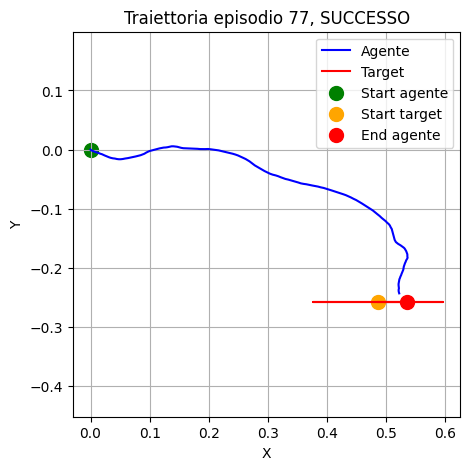

Episode: 80, Step: 400, Counter: 10, Total reward: -781.2255859375, final state: tensor([-0.3657,  0.0924, -0.1522,  0.1323])
SUCCESSO Episode: 81, Step: 304, Counter: 11, Total reward: -162.26710510253906, final state: tensor([0.2491, 0.0303, 0.2335, 0.0358])
SUCCESSO Episode: 87, Step: 137, Counter: 12, Total reward: 355.7455139160156, final state: tensor([ 0.2546, -0.3089,  0.2552, -0.3256])
SUCCESSO Episode: 90, Step: 129, Counter: 13, Total reward: 399.5025634765625, final state: tensor([-0.0638, -0.3714, -0.0689, -0.3865])
Episode: 90, Step: 129, Counter: 13, Total reward: 399.5025634765625, final state: tensor([-0.0638, -0.3714, -0.0689, -0.3865])
SUCCESSO Episode: 94, Step: 94, Counter: 14, Total reward: 490.5675964355469, final state: tensor([ 0.0754, -0.2717,  0.0897, -0.2581])
Episode: 100, Step: 400, Counter: 14, Total reward: -756.4027709960938, final state: tensor([ 0.6049, -0.7846,  0.1420, -0.4159])
Episode: 110, Step: 400, Counter: 14, Total reward: -703.881591796875, 

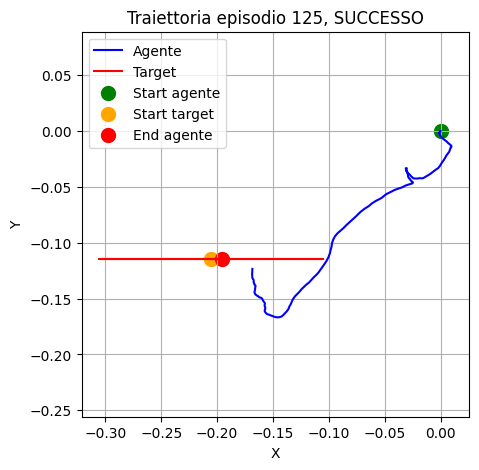

SUCCESSO Episode: 127, Step: 195, Counter: 21, Total reward: 237.22186279296875, final state: tensor([-0.3084,  0.0498, -0.3005,  0.0568])
SUCCESSO Episode: 129, Step: 188, Counter: 22, Total reward: 252.7120361328125, final state: tensor([-0.0230, -0.4123, -0.0099, -0.4028])
Episode: 130, Step: 400, Counter: 22, Total reward: -684.2689819335938, final state: tensor([0.1781, 1.0352, 0.1150, 0.4901])
SUCCESSO Episode: 132, Step: 233, Counter: 23, Total reward: 181.23526000976562, final state: tensor([0.4545, 0.2256, 0.4674, 0.2408])
SUCCESSO Episode: 134, Step: 167, Counter: 24, Total reward: 312.3257751464844, final state: tensor([-0.1380, -0.1979, -0.1505, -0.2064])
SUCCESSO Episode: 135, Step: 345, Counter: 25, Total reward: -323.56439208984375, final state: tensor([0.2427, 0.2908, 0.2394, 0.3101])
SUCCESSO Episode: 138, Step: 149, Counter: 26, Total reward: 299.57672119140625, final state: tensor([0.3339, 0.1456, 0.3483, 0.1500])
SUCCESSO Episode: 139, Step: 270, Counter: 27, Total 

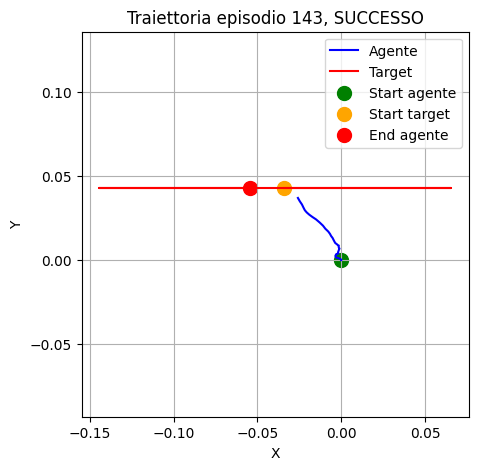

SUCCESSO Episode: 146, Step: 77, Counter: 31, Total reward: 488.719482421875, final state: tensor([ 0.2125, -0.1231,  0.2126, -0.1398])
SUCCESSO Episode: 148, Step: 110, Counter: 32, Total reward: 416.9597473144531, final state: tensor([ 0.2622, -0.2738,  0.2700, -0.2842])
Episode: 150, Step: 400, Counter: 32, Total reward: -894.4741821289062, final state: tensor([-0.4328,  0.6426, -0.4083,  0.0314])
SUCCESSO Episode: 151, Step: 341, Counter: 33, Total reward: -312.2254333496094, final state: tensor([0.0844, 0.1550, 0.0906, 0.1374])
SUCCESSO Episode: 152, Step: 303, Counter: 34, Total reward: -45.05891418457031, final state: tensor([0.3217, 0.4880, 0.3161, 0.4759])
SUCCESSO Episode: 154, Step: 77, Counter: 35, Total reward: 530.2842407226562, final state: tensor([ 0.1897, -0.2157,  0.1852, -0.2292])
SUCCESSO Episode: 155, Step: 150, Counter: 36, Total reward: 400.15283203125, final state: tensor([-0.1150, -0.4228, -0.1010, -0.4215])
SUCCESSO Episode: 158, Step: 116, Counter: 37, Total 

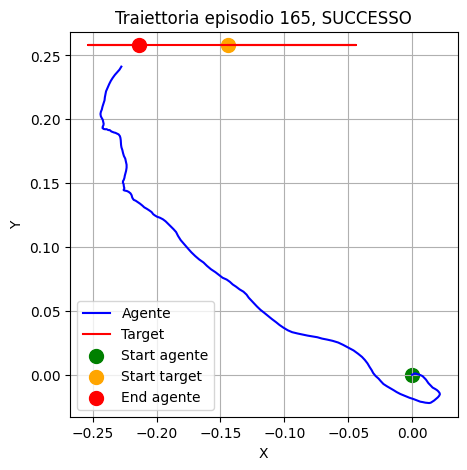

SUCCESSO Episode: 166, Step: 313, Counter: 41, Total reward: -168.99752807617188, final state: tensor([-0.4285, -0.4023, -0.4356, -0.3839])
SUCCESSO Episode: 167, Step: 355, Counter: 42, Total reward: -254.61961364746094, final state: tensor([-0.4116, -0.4651, -0.4240, -0.4593])
SUCCESSO Episode: 170, Step: 45, Counter: 43, Total reward: 455.0019226074219, final state: tensor([ 0.0477, -0.0101,  0.0416, -0.0265])
Episode: 170, Step: 45, Counter: 43, Total reward: 455.0019226074219, final state: tensor([ 0.0477, -0.0101,  0.0416, -0.0265])
SUCCESSO Episode: 171, Step: 117, Counter: 44, Total reward: 457.661376953125, final state: tensor([-0.3991, -0.0492, -0.3968, -0.0661])
SUCCESSO Episode: 172, Step: 394, Counter: 45, Total reward: -617.5877075195312, final state: tensor([-0.0761,  0.1031, -0.0615,  0.1159])
SUCCESSO Episode: 173, Step: 111, Counter: 46, Total reward: 488.3602294921875, final state: tensor([ 0.0751, -0.4692,  0.0851, -0.4547])
SUCCESSO Episode: 174, Step: 186, Counter

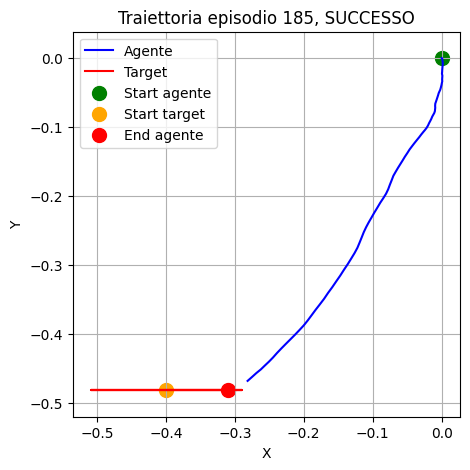

SUCCESSO Episode: 188, Step: 108, Counter: 51, Total reward: 530.4662475585938, final state: tensor([ 0.3520, -0.4697,  0.3649, -0.4767])
SUCCESSO Episode: 189, Step: 71, Counter: 52, Total reward: 498.79010009765625, final state: tensor([ 0.2532, -0.2131,  0.2645, -0.2181])
SUCCESSO Episode: 190, Step: 105, Counter: 53, Total reward: 463.5529479980469, final state: tensor([-0.3479,  0.1875, -0.3318,  0.1967])
Episode: 190, Step: 105, Counter: 53, Total reward: 463.5529479980469, final state: tensor([-0.3479,  0.1875, -0.3318,  0.1967])
SUCCESSO Episode: 194, Step: 100, Counter: 54, Total reward: 448.85791015625, final state: tensor([0.3427, 0.2900, 0.3506, 0.3068])
SUCCESSO Episode: 195, Step: 111, Counter: 55, Total reward: 467.8233337402344, final state: tensor([ 0.4704, -0.0710,  0.4805, -0.0874])
SUCCESSO Episode: 199, Step: 105, Counter: 56, Total reward: 474.7869873046875, final state: tensor([0.2905, 0.2577, 0.3009, 0.2545])
SUCCESSO Episode: 200, Step: 170, Counter: 57, Total 

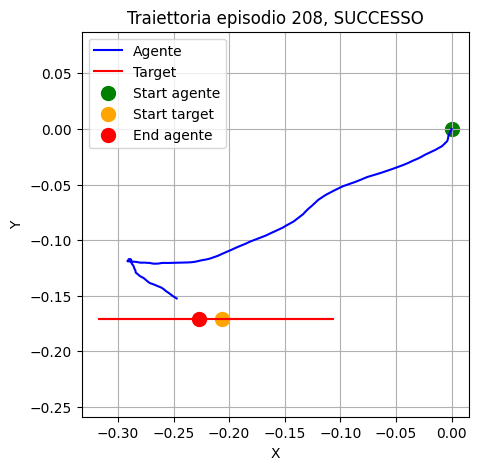

Episode: 210, Step: 400, Counter: 60, Total reward: -646.101318359375, final state: tensor([0.6224, 0.4388, 0.3316, 0.2896])
SUCCESSO Episode: 211, Step: 158, Counter: 61, Total reward: 346.73431396484375, final state: tensor([-0.4546, -0.0242, -0.4488, -0.0056])
SUCCESSO Episode: 212, Step: 340, Counter: 62, Total reward: -261.93170166015625, final state: tensor([-0.5613,  0.0478, -0.5424,  0.0495])
SUCCESSO Episode: 213, Step: 130, Counter: 63, Total reward: 424.40386962890625, final state: tensor([-0.0074,  0.3985, -0.0185,  0.3877])
SUCCESSO Episode: 214, Step: 81, Counter: 64, Total reward: 538.1051635742188, final state: tensor([-0.1745, -0.3977, -0.1791, -0.3829])
SUCCESSO Episode: 218, Step: 202, Counter: 65, Total reward: 303.06683349609375, final state: tensor([-0.4748,  0.3074, -0.4672,  0.3219])
SUCCESSO Episode: 219, Step: 82, Counter: 66, Total reward: 630.377685546875, final state: tensor([ 0.2020, -0.4069,  0.1862, -0.4187])
SUCCESSO Episode: 220, Step: 380, Counter: 67

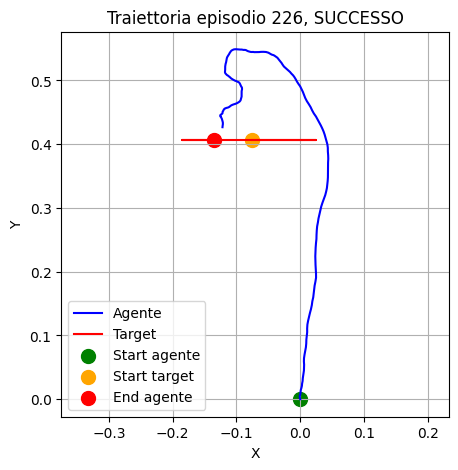

SUCCESSO Episode: 227, Step: 350, Counter: 71, Total reward: -158.4400634765625, final state: tensor([-0.4099, -0.0265, -0.4088, -0.0074])
Episode: 230, Step: 400, Counter: 71, Total reward: -571.523193359375, final state: tensor([-0.3750,  0.0948, -0.3425,  0.1492])
SUCCESSO Episode: 231, Step: 227, Counter: 72, Total reward: 219.55239868164062, final state: tensor([0.3179, 0.0668, 0.3160, 0.0834])
SUCCESSO Episode: 233, Step: 88, Counter: 73, Total reward: 522.1217041015625, final state: tensor([-0.1558,  0.3659, -0.1743,  0.3686])
SUCCESSO Episode: 235, Step: 129, Counter: 74, Total reward: 472.6484680175781, final state: tensor([-0.4543,  0.4580, -0.4578,  0.4699])
SUCCESSO Episode: 237, Step: 282, Counter: 75, Total reward: -16.907760620117188, final state: tensor([-0.0650,  0.4932, -0.0523,  0.4930])
SUCCESSO Episode: 238, Step: 153, Counter: 76, Total reward: 390.42559814453125, final state: tensor([-0.4863,  0.0412, -0.4762,  0.0539])
SUCCESSO Episode: 240, Step: 64, Counter: 7

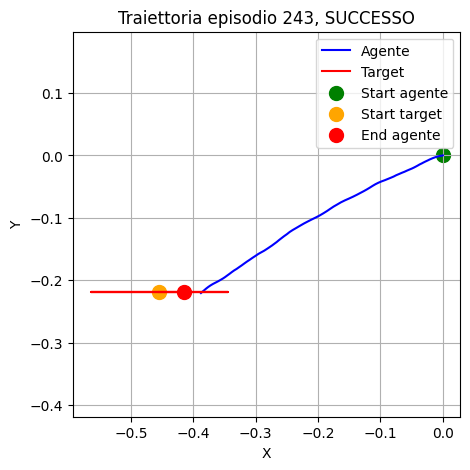

SUCCESSO Episode: 244, Step: 72, Counter: 81, Total reward: 571.7617797851562, final state: tensor([0.3352, 0.4006, 0.3504, 0.3903])
SUCCESSO Episode: 245, Step: 59, Counter: 82, Total reward: 511.9086608886719, final state: tensor([-0.0129,  0.1021, -0.0143,  0.1201])
SUCCESSO Episode: 247, Step: 70, Counter: 83, Total reward: 461.1908874511719, final state: tensor([-0.0937, -0.1483, -0.0763, -0.1466])
SUCCESSO Episode: 248, Step: 74, Counter: 84, Total reward: 606.9286499023438, final state: tensor([ 0.0419, -0.4287,  0.0237, -0.4223])
SUCCESSO Episode: 250, Step: 163, Counter: 85, Total reward: 408.4544372558594, final state: tensor([0.1584, 0.0510, 0.1482, 0.0361])
Episode: 250, Step: 163, Counter: 85, Total reward: 408.4544372558594, final state: tensor([0.1584, 0.0510, 0.1482, 0.0361])
SUCCESSO Episode: 254, Step: 295, Counter: 86, Total reward: 28.61181640625, final state: tensor([0.3541, 0.2448, 0.3598, 0.2257])
SUCCESSO Episode: 255, Step: 62, Counter: 87, Total reward: 504.05

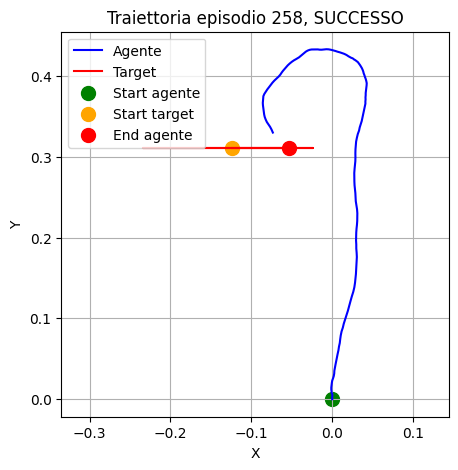

SUCCESSO Episode: 260, Step: 58, Counter: 91, Total reward: 569.1253051757812, final state: tensor([ 0.1059, -0.1351,  0.1141, -0.1191])
Episode: 260, Step: 58, Counter: 91, Total reward: 569.1253051757812, final state: tensor([ 0.1059, -0.1351,  0.1141, -0.1191])
SUCCESSO Episode: 263, Step: 56, Counter: 92, Total reward: 560.6635131835938, final state: tensor([-0.0548, -0.2104, -0.0452, -0.2266])
SUCCESSO Episode: 264, Step: 272, Counter: 93, Total reward: 173.1116943359375, final state: tensor([-0.4382,  0.3631, -0.4236,  0.3647])
SUCCESSO Episode: 265, Step: 224, Counter: 94, Total reward: 328.10540771484375, final state: tensor([0.3645, 0.5118, 0.3529, 0.4997])
SUCCESSO Episode: 266, Step: 251, Counter: 95, Total reward: 157.6278076171875, final state: tensor([0.3924, 0.0576, 0.4066, 0.0554])
SUCCESSO Episode: 267, Step: 315, Counter: 96, Total reward: -73.82771301269531, final state: tensor([0.3519, 0.4543, 0.3390, 0.4448])
SUCCESSO Episode: 268, Step: 86, Counter: 97, Total rewa

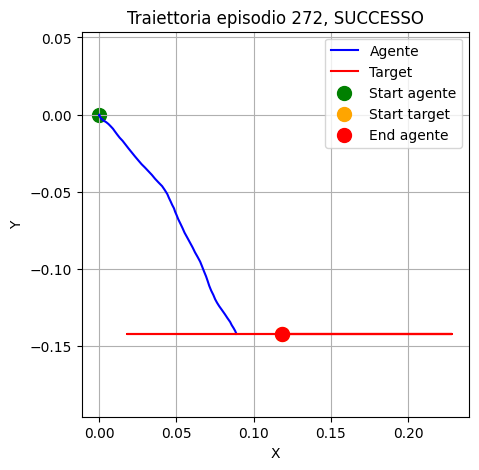

SUCCESSO Episode: 273, Step: 130, Counter: 101, Total reward: 536.0855102539062, final state: tensor([-0.4041,  0.1882, -0.4064,  0.1716])
SUCCESSO Episode: 274, Step: 159, Counter: 102, Total reward: 497.7043762207031, final state: tensor([-0.0444,  0.2721, -0.0297,  0.2723])
SUCCESSO Episode: 275, Step: 170, Counter: 103, Total reward: 391.53045654296875, final state: tensor([0.1353, 0.3462, 0.1202, 0.3522])
SUCCESSO Episode: 276, Step: 62, Counter: 104, Total reward: 440.3305358886719, final state: tensor([0.0598, 0.0568, 0.0719, 0.0609])
SUCCESSO Episode: 277, Step: 115, Counter: 105, Total reward: 518.4125366210938, final state: tensor([ 0.3284, -0.0793,  0.3267, -0.0965])
SUCCESSO Episode: 279, Step: 285, Counter: 106, Total reward: 117.9113540649414, final state: tensor([0.2616, 0.1399, 0.2651, 0.1203])
SUCCESSO Episode: 280, Step: 74, Counter: 107, Total reward: 602.295166015625, final state: tensor([ 0.1311, -0.2731,  0.1441, -0.2870])
Episode: 280, Step: 74, Counter: 107, Tot

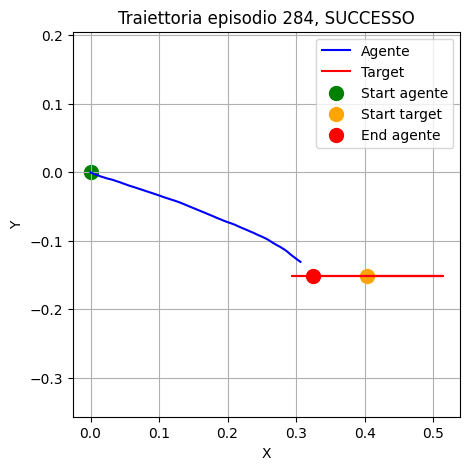

SUCCESSO Episode: 285, Step: 154, Counter: 111, Total reward: 532.1010131835938, final state: tensor([0.0076, 0.2925, 0.0140, 0.2837])
SUCCESSO Episode: 286, Step: 83, Counter: 112, Total reward: 462.0744323730469, final state: tensor([-0.0650,  0.1124, -0.0735,  0.1221])
SUCCESSO Episode: 287, Step: 260, Counter: 113, Total reward: 316.1697082519531, final state: tensor([0.3321, 0.4351, 0.3224, 0.4495])
SUCCESSO Episode: 288, Step: 103, Counter: 114, Total reward: 584.8723754882812, final state: tensor([-0.2999,  0.4240, -0.2829,  0.4266])
SUCCESSO Episode: 289, Step: 75, Counter: 115, Total reward: 558.88720703125, final state: tensor([-0.0419, -0.2436, -0.0579, -0.2418])
SUCCESSO Episode: 290, Step: 90, Counter: 116, Total reward: 562.3948364257812, final state: tensor([0.0267, 0.4670, 0.0191, 0.4800])
Episode: 290, Step: 90, Counter: 116, Total reward: 562.3948364257812, final state: tensor([0.0267, 0.4670, 0.0191, 0.4800])
SUCCESSO Episode: 291, Step: 226, Counter: 117, Total rewa

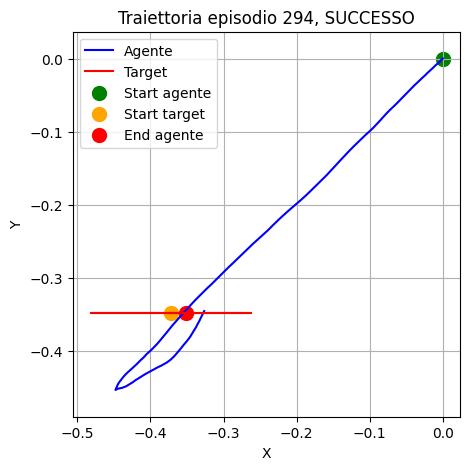

SUCCESSO Episode: 295, Step: 90, Counter: 121, Total reward: 526.8547973632812, final state: tensor([-0.3436,  0.1237, -0.3412,  0.1409])
SUCCESSO Episode: 296, Step: 58, Counter: 122, Total reward: 588.6323852539062, final state: tensor([-0.2510, -0.1404, -0.2381, -0.1543])
SUCCESSO Episode: 297, Step: 71, Counter: 123, Total reward: 526.607421875, final state: tensor([ 0.3381, -0.0176,  0.3468, -0.0260])
SUCCESSO Episode: 299, Step: 219, Counter: 124, Total reward: 419.60052490234375, final state: tensor([-0.3033, -0.4700, -0.3177, -0.4591])
SUCCESSO Episode: 300, Step: 157, Counter: 125, Total reward: 612.561279296875, final state: tensor([-0.3604, -0.2405, -0.3611, -0.2214])
Episode: 300, Step: 157, Counter: 125, Total reward: 612.561279296875, final state: tensor([-0.3604, -0.2405, -0.3611, -0.2214])
SUCCESSO Episode: 301, Step: 195, Counter: 126, Total reward: 521.3125610351562, final state: tensor([-0.3070, -0.4158, -0.2930, -0.4113])
SUCCESSO Episode: 302, Step: 265, Counter: 1

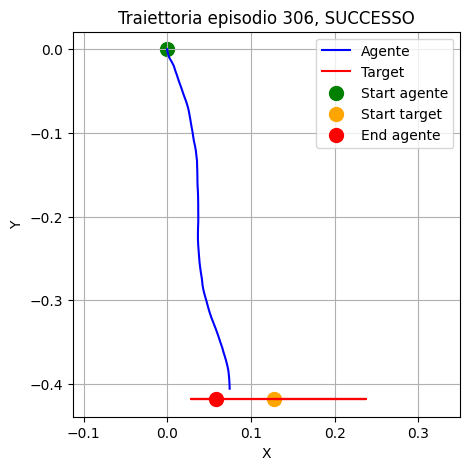

SUCCESSO Episode: 307, Step: 107, Counter: 131, Total reward: 534.601318359375, final state: tensor([0.3865, 0.4236, 0.4036, 0.4209])
SUCCESSO Episode: 309, Step: 68, Counter: 132, Total reward: 563.741943359375, final state: tensor([0.2729, 0.2531, 0.2862, 0.2483])
SUCCESSO Episode: 310, Step: 194, Counter: 133, Total reward: 518.9429321289062, final state: tensor([-0.2923, -0.2987, -0.2755, -0.2907])
Episode: 310, Step: 194, Counter: 133, Total reward: 518.9429321289062, final state: tensor([-0.2923, -0.2987, -0.2755, -0.2907])
SUCCESSO Episode: 311, Step: 45, Counter: 134, Total reward: 519.3775634765625, final state: tensor([-0.0847, -0.0175, -0.0995, -0.0155])
SUCCESSO Episode: 312, Step: 61, Counter: 135, Total reward: 498.49676513671875, final state: tensor([ 0.1022, -0.1150,  0.1083, -0.1311])
SUCCESSO Episode: 313, Step: 90, Counter: 136, Total reward: 565.123779296875, final state: tensor([-0.0020,  0.2407, -0.0175,  0.2475])
SUCCESSO Episode: 314, Step: 253, Counter: 137, To

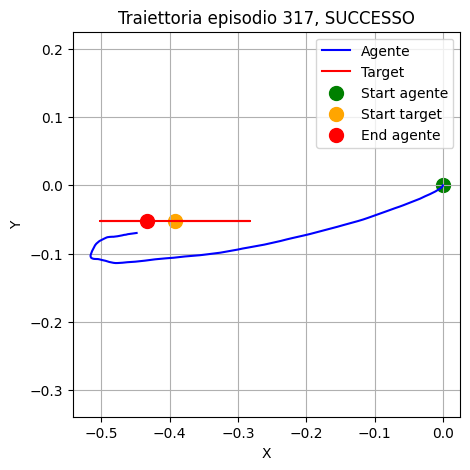

SUCCESSO Episode: 318, Step: 71, Counter: 141, Total reward: 577.1056518554688, final state: tensor([-0.0289, -0.2531, -0.0174, -0.2575])
SUCCESSO Episode: 319, Step: 51, Counter: 142, Total reward: 558.3474731445312, final state: tensor([-0.1297, -0.1323, -0.1408, -0.1227])
SUCCESSO Episode: 320, Step: 212, Counter: 143, Total reward: 499.08294677734375, final state: tensor([-0.4495, -0.1789, -0.4599, -0.1779])
Episode: 320, Step: 212, Counter: 143, Total reward: 499.08294677734375, final state: tensor([-0.4495, -0.1789, -0.4599, -0.1779])
SUCCESSO Episode: 321, Step: 60, Counter: 144, Total reward: 579.0948486328125, final state: tensor([-0.2470, -0.1734, -0.2286, -0.1725])
SUCCESSO Episode: 323, Step: 68, Counter: 145, Total reward: 539.7301635742188, final state: tensor([0.0419, 0.1838, 0.0536, 0.1791])
SUCCESSO Episode: 324, Step: 75, Counter: 146, Total reward: 509.9996337890625, final state: tensor([ 0.1979,  0.0146,  0.1992, -0.0016])
SUCCESSO Episode: 325, Step: 173, Counter: 

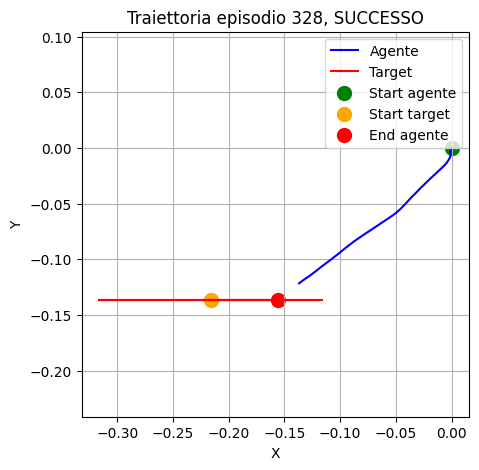

SUCCESSO Episode: 329, Step: 127, Counter: 151, Total reward: 415.1783142089844, final state: tensor([0.1680, 0.0749, 0.1559, 0.0708])
SUCCESSO Episode: 330, Step: 94, Counter: 152, Total reward: 522.11572265625, final state: tensor([-0.0306,  0.4966, -0.0439,  0.4865])
Episode: 330, Step: 94, Counter: 152, Total reward: 522.11572265625, final state: tensor([-0.0306,  0.4966, -0.0439,  0.4865])
SUCCESSO Episode: 331, Step: 67, Counter: 153, Total reward: 601.1441650390625, final state: tensor([ 0.0694, -0.2484,  0.0758, -0.2628])
SUCCESSO Episode: 332, Step: 156, Counter: 154, Total reward: 655.5908813476562, final state: tensor([-0.4256, -0.3609, -0.4182, -0.3471])
SUCCESSO Episode: 333, Step: 197, Counter: 155, Total reward: 497.5643005371094, final state: tensor([-0.2521, -0.3450, -0.2440, -0.3393])
SUCCESSO Episode: 334, Step: 61, Counter: 156, Total reward: 599.5850219726562, final state: tensor([-0.2677, -0.1959, -0.2634, -0.2149])
SUCCESSO Episode: 335, Step: 102, Counter: 157, 

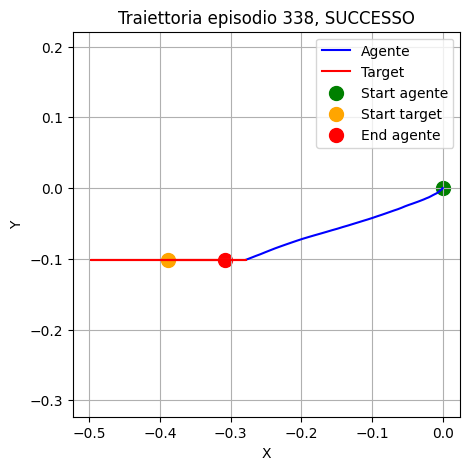

SUCCESSO Episode: 339, Step: 153, Counter: 161, Total reward: 479.14886474609375, final state: tensor([0.3841, 0.3776, 0.3995, 0.3655])
SUCCESSO Episode: 340, Step: 74, Counter: 162, Total reward: 590.1752319335938, final state: tensor([ 0.2226, -0.2377,  0.2371, -0.2421])
Episode: 340, Step: 74, Counter: 162, Total reward: 590.1752319335938, final state: tensor([ 0.2226, -0.2377,  0.2371, -0.2421])
SUCCESSO Episode: 341, Step: 113, Counter: 163, Total reward: 517.7008666992188, final state: tensor([-0.3648,  0.1842, -0.3591,  0.1686])
SUCCESSO Episode: 342, Step: 73, Counter: 164, Total reward: 602.8719482421875, final state: tensor([0.3554, 0.0691, 0.3594, 0.0568])
SUCCESSO Episode: 343, Step: 67, Counter: 165, Total reward: 571.11083984375, final state: tensor([ 0.0295, -0.2123,  0.0416, -0.2200])
SUCCESSO Episode: 344, Step: 73, Counter: 166, Total reward: 584.1198120117188, final state: tensor([ 0.1808, -0.3186,  0.1995, -0.3130])
SUCCESSO Episode: 345, Step: 183, Counter: 167, To

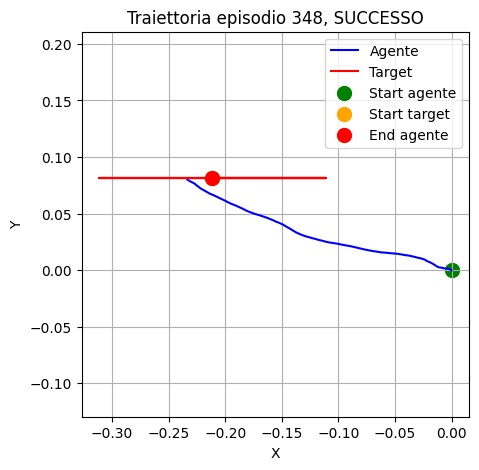

SUCCESSO Episode: 349, Step: 154, Counter: 171, Total reward: 515.2258911132812, final state: tensor([-0.3573, -0.0218, -0.3456, -0.0189])
SUCCESSO Episode: 350, Step: 215, Counter: 172, Total reward: 557.8160400390625, final state: tensor([-0.0117, -0.4612, -0.0174, -0.4482])
Episode: 350, Step: 215, Counter: 172, Total reward: 557.8160400390625, final state: tensor([-0.0117, -0.4612, -0.0174, -0.4482])
SUCCESSO Episode: 351, Step: 176, Counter: 173, Total reward: 646.1541748046875, final state: tensor([-0.1405, -0.3715, -0.1234, -0.3656])
SUCCESSO Episode: 352, Step: 187, Counter: 174, Total reward: 355.8360290527344, final state: tensor([-0.3144,  0.4891, -0.3266,  0.4900])
SUCCESSO Episode: 353, Step: 149, Counter: 175, Total reward: 498.92327880859375, final state: tensor([-0.2197,  0.3088, -0.2076,  0.3099])
SUCCESSO Episode: 354, Step: 86, Counter: 176, Total reward: 532.238525390625, final state: tensor([-0.2234,  0.1656, -0.2254,  0.1815])
SUCCESSO Episode: 355, Step: 69, Coun

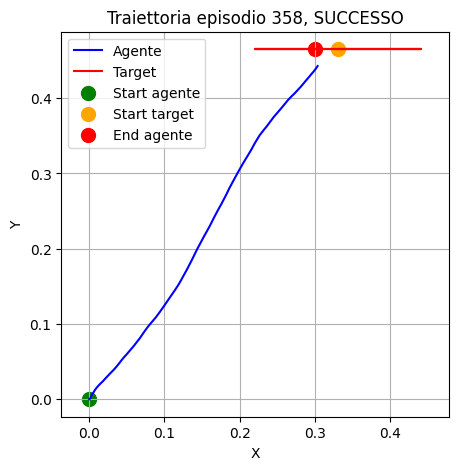

SUCCESSO Episode: 359, Step: 129, Counter: 181, Total reward: 508.92803955078125, final state: tensor([-0.3950,  0.2174, -0.4057,  0.2309])
Episode: 360, Step: 400, Counter: 181, Total reward: -406.29742431640625, final state: tensor([ 0.3466, -0.4139,  0.4783, -0.3188])
SUCCESSO Episode: 361, Step: 186, Counter: 182, Total reward: 470.36285400390625, final state: tensor([-0.4057,  0.2562, -0.3935,  0.2411])
SUCCESSO Episode: 362, Step: 168, Counter: 183, Total reward: 482.29534912109375, final state: tensor([0.0906, 0.3372, 0.0745, 0.3418])
SUCCESSO Episode: 363, Step: 129, Counter: 184, Total reward: 462.6051940917969, final state: tensor([-0.3739,  0.2981, -0.3902,  0.2953])
SUCCESSO Episode: 364, Step: 330, Counter: 185, Total reward: 215.30242919921875, final state: tensor([-0.3012, -0.3494, -0.2984, -0.3363])
SUCCESSO Episode: 365, Step: 132, Counter: 186, Total reward: 531.8397216796875, final state: tensor([-0.3287,  0.3021, -0.3357,  0.3146])
SUCCESSO Episode: 366, Step: 29, C

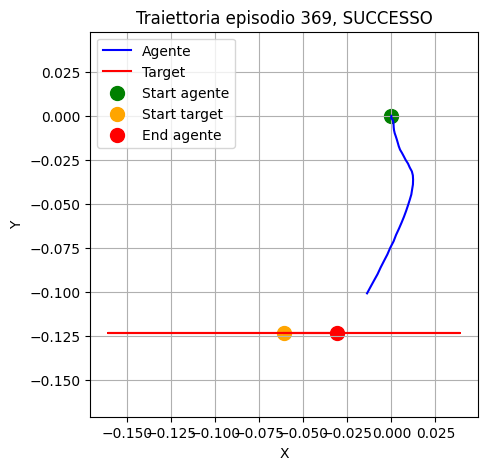

SUCCESSO Episode: 370, Step: 60, Counter: 191, Total reward: 617.1921997070312, final state: tensor([-0.0072, -0.2091,  0.0027, -0.1986])
Episode: 370, Step: 60, Counter: 191, Total reward: 617.1921997070312, final state: tensor([-0.0072, -0.2091,  0.0027, -0.1986])
SUCCESSO Episode: 372, Step: 102, Counter: 192, Total reward: 571.5297241210938, final state: tensor([-0.2010,  0.3998, -0.1878,  0.3996])
SUCCESSO Episode: 373, Step: 146, Counter: 193, Total reward: 417.4766845703125, final state: tensor([-0.1293,  0.0319, -0.1161,  0.0436])
SUCCESSO Episode: 374, Step: 75, Counter: 194, Total reward: 570.7822265625, final state: tensor([0.3161, 0.1399, 0.3165, 0.1242])
SUCCESSO Episode: 375, Step: 106, Counter: 195, Total reward: 567.1229248046875, final state: tensor([-0.3484,  0.4275, -0.3431,  0.4398])
SUCCESSO Episode: 376, Step: 62, Counter: 196, Total reward: 580.680908203125, final state: tensor([ 0.1443, -0.1560,  0.1477, -0.1651])
SUCCESSO Episode: 377, Step: 316, Counter: 197, 

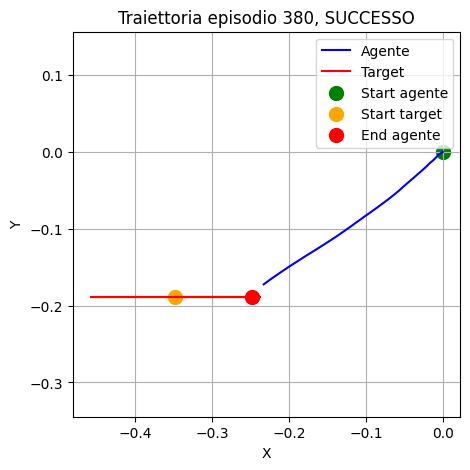

Episode: 380, Step: 55, Counter: 200, Total reward: 630.6610717773438, final state: tensor([-0.2386, -0.1765, -0.2383, -0.1883])
SUCCESSO Episode: 381, Step: 91, Counter: 201, Total reward: 574.3653564453125, final state: tensor([-0.2165,  0.2295, -0.2215,  0.2439])
SUCCESSO Episode: 382, Step: 151, Counter: 202, Total reward: 588.6607666015625, final state: tensor([-0.5019,  0.0858, -0.4965,  0.0699])
SUCCESSO Episode: 383, Step: 71, Counter: 203, Total reward: 621.2554321289062, final state: tensor([0.2160, 0.3617, 0.2125, 0.3768])
SUCCESSO Episode: 384, Step: 212, Counter: 204, Total reward: 402.53985595703125, final state: tensor([-0.1283,  0.3381, -0.1379,  0.3213])
SUCCESSO Episode: 385, Step: 357, Counter: 205, Total reward: 80.17868041992188, final state: tensor([-0.3356,  0.3277, -0.3394,  0.3465])
SUCCESSO Episode: 386, Step: 157, Counter: 206, Total reward: 589.3239135742188, final state: tensor([-0.4141, -0.1016, -0.4025, -0.1027])
SUCCESSO Episode: 388, Step: 347, Counter:

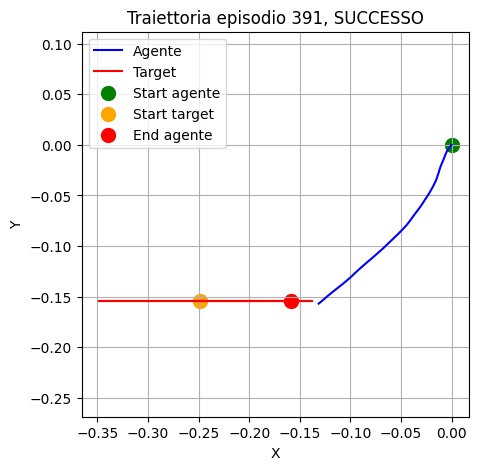

SUCCESSO Episode: 392, Step: 191, Counter: 211, Total reward: 424.5948181152344, final state: tensor([-0.2597,  0.4188, -0.2484,  0.4085])
SUCCESSO Episode: 393, Step: 60, Counter: 212, Total reward: 551.7897338867188, final state: tensor([ 0.0692, -0.1025,  0.0834, -0.0991])
SUCCESSO Episode: 394, Step: 81, Counter: 213, Total reward: 615.880859375, final state: tensor([-0.0141,  0.4375, -0.0280,  0.4473])
SUCCESSO Episode: 395, Step: 157, Counter: 214, Total reward: 546.575439453125, final state: tensor([-0.3925,  0.0901, -0.3766,  0.0862])
SUCCESSO Episode: 396, Step: 59, Counter: 215, Total reward: 552.8696899414062, final state: tensor([0.0011, 0.1080, 0.0159, 0.1115])
SUCCESSO Episode: 397, Step: 279, Counter: 216, Total reward: 322.4866943359375, final state: tensor([-0.4178,  0.3555, -0.4119,  0.3721])
SUCCESSO Episode: 398, Step: 68, Counter: 217, Total reward: 594.4620971679688, final state: tensor([0.3734, 0.0809, 0.3721, 0.0651])
SUCCESSO Episode: 399, Step: 73, Counter: 21

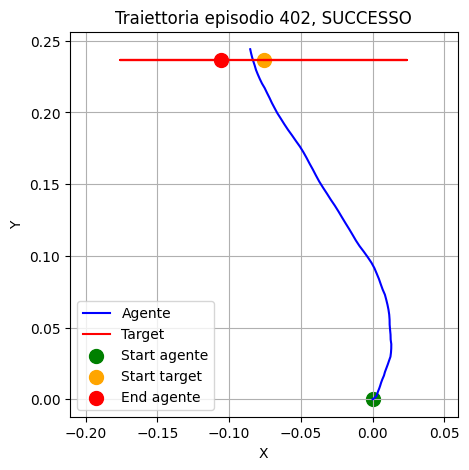

SUCCESSO Episode: 403, Step: 157, Counter: 221, Total reward: 476.09161376953125, final state: tensor([0.3146, 0.4368, 0.3244, 0.4256])
SUCCESSO Episode: 404, Step: 228, Counter: 222, Total reward: 541.696044921875, final state: tensor([-0.0363, -0.4041, -0.0292, -0.3868])
SUCCESSO Episode: 405, Step: 76, Counter: 223, Total reward: 590.3502197265625, final state: tensor([0.3776, 0.3214, 0.3848, 0.3389])
SUCCESSO Episode: 406, Step: 87, Counter: 224, Total reward: 659.5197143554688, final state: tensor([-0.3850,  0.4054, -0.3853,  0.4208])
SUCCESSO Episode: 407, Step: 88, Counter: 225, Total reward: 603.662353515625, final state: tensor([0.3799, 0.0216, 0.3699, 0.0188])
SUCCESSO Episode: 408, Step: 62, Counter: 226, Total reward: 522.1396484375, final state: tensor([ 0.1059, -0.0891,  0.1113, -0.1010])
SUCCESSO Episode: 409, Step: 148, Counter: 227, Total reward: 620.559814453125, final state: tensor([-0.4562, -0.1730, -0.4452, -0.1648])
Episode: 410, Step: 400, Counter: 227, Total rew

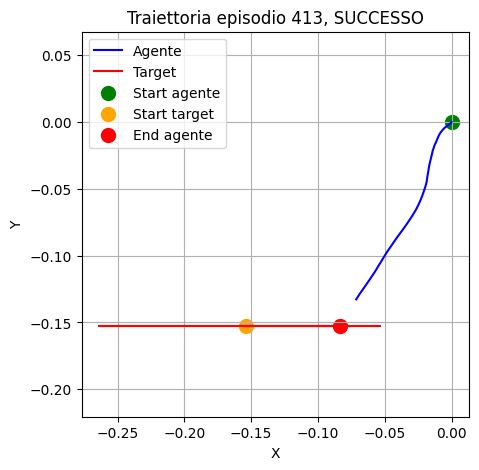

SUCCESSO Episode: 414, Step: 64, Counter: 231, Total reward: 598.6212158203125, final state: tensor([ 0.2106, -0.0611,  0.2175, -0.0478])
SUCCESSO Episode: 415, Step: 130, Counter: 232, Total reward: 559.830078125, final state: tensor([-0.2932, -0.0632, -0.2954, -0.0476])
SUCCESSO Episode: 416, Step: 185, Counter: 233, Total reward: 634.6510009765625, final state: tensor([-0.2626, -0.3102, -0.2691, -0.3236])
SUCCESSO Episode: 417, Step: 42, Counter: 234, Total reward: 551.0640258789062, final state: tensor([ 0.0189, -0.0637,  0.0184, -0.0811])
SUCCESSO Episode: 418, Step: 83, Counter: 235, Total reward: 640.3038330078125, final state: tensor([ 0.3792, -0.1245,  0.3648, -0.1376])
SUCCESSO Episode: 419, Step: 84, Counter: 236, Total reward: 524.1216430664062, final state: tensor([0.1378, 0.1236, 0.1206, 0.1323])
SUCCESSO Episode: 420, Step: 114, Counter: 237, Total reward: 633.996826171875, final state: tensor([-0.5435,  0.1552, -0.5269,  0.1635])
Episode: 420, Step: 114, Counter: 237, T

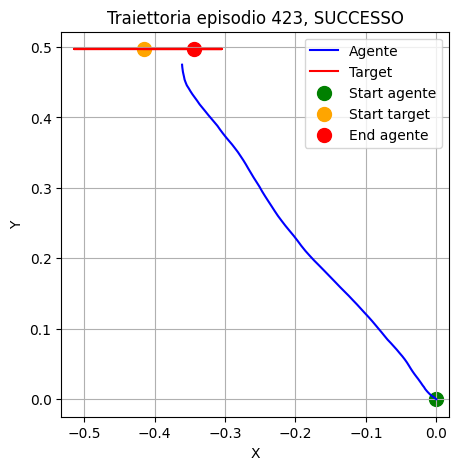

SUCCESSO Episode: 424, Step: 59, Counter: 241, Total reward: 549.503173828125, final state: tensor([0.0141, 0.0880, 0.0322, 0.0954])
SUCCESSO Episode: 425, Step: 113, Counter: 242, Total reward: 607.6748657226562, final state: tensor([-0.4722,  0.2660, -0.4629,  0.2500])
SUCCESSO Episode: 426, Step: 97, Counter: 243, Total reward: 588.4575805664062, final state: tensor([-0.1821,  0.4048, -0.2001,  0.3981])
SUCCESSO Episode: 427, Step: 184, Counter: 244, Total reward: 620.6784057617188, final state: tensor([-0.2050, -0.2976, -0.2149, -0.3093])
SUCCESSO Episode: 428, Step: 160, Counter: 245, Total reward: 565.5245361328125, final state: tensor([-0.5303, -0.0149, -0.5235, -0.0279])
SUCCESSO Episode: 429, Step: 213, Counter: 246, Total reward: 668.8677368164062, final state: tensor([ 0.0913, -0.4527,  0.0948, -0.4343])
SUCCESSO Episode: 430, Step: 66, Counter: 247, Total reward: 614.390625, final state: tensor([ 0.2687, -0.0403,  0.2755, -0.0467])
Episode: 430, Step: 66, Counter: 247, Tota

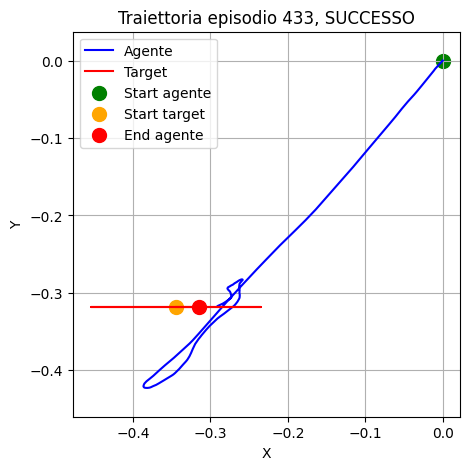

SUCCESSO Episode: 434, Step: 251, Counter: 251, Total reward: 453.098876953125, final state: tensor([0.2655, 0.4290, 0.2718, 0.4461])
SUCCESSO Episode: 435, Step: 58, Counter: 252, Total reward: 641.4208374023438, final state: tensor([-0.1036, -0.2238, -0.0867, -0.2293])
SUCCESSO Episode: 436, Step: 58, Counter: 253, Total reward: 595.8950805664062, final state: tensor([ 0.1857, -0.0912,  0.2040, -0.0913])
SUCCESSO Episode: 437, Step: 151, Counter: 254, Total reward: 699.707275390625, final state: tensor([-0.4530, -0.3560, -0.4446, -0.3438])
SUCCESSO Episode: 438, Step: 226, Counter: 255, Total reward: 402.8049011230469, final state: tensor([0.1484, 0.1433, 0.1560, 0.1589])
SUCCESSO Episode: 439, Step: 158, Counter: 256, Total reward: 621.9443359375, final state: tensor([-0.5216, -0.2747, -0.5129, -0.2780])
SUCCESSO Episode: 440, Step: 87, Counter: 257, Total reward: 608.5877685546875, final state: tensor([-0.2769,  0.1573, -0.2789,  0.1719])
Episode: 440, Step: 87, Counter: 257, Total

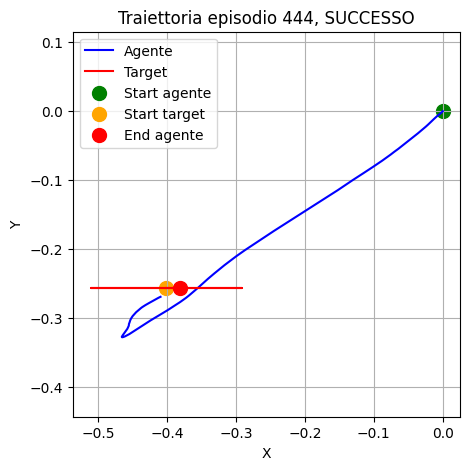

SUCCESSO Episode: 445, Step: 62, Counter: 261, Total reward: 655.1913452148438, final state: tensor([0.1910, 0.3472, 0.2023, 0.3557])
SUCCESSO Episode: 446, Step: 67, Counter: 262, Total reward: 624.2727661132812, final state: tensor([ 0.3256, -0.0866,  0.3202, -0.1028])
SUCCESSO Episode: 448, Step: 173, Counter: 263, Total reward: 638.44482421875, final state: tensor([-0.1552,  0.4013, -0.1369,  0.3963])
SUCCESSO Episode: 449, Step: 148, Counter: 264, Total reward: 745.1085205078125, final state: tensor([-0.5054, -0.4208, -0.4870, -0.4145])
SUCCESSO Episode: 450, Step: 268, Counter: 265, Total reward: 527.7337646484375, final state: tensor([-0.2405, -0.4670, -0.2521, -0.4735])
Episode: 450, Step: 268, Counter: 265, Total reward: 527.7337646484375, final state: tensor([-0.2405, -0.4670, -0.2521, -0.4735])
SUCCESSO Episode: 451, Step: 84, Counter: 266, Total reward: 605.8889770507812, final state: tensor([-0.3486,  0.0677, -0.3586,  0.0830])
SUCCESSO Episode: 452, Step: 302, Counter: 26

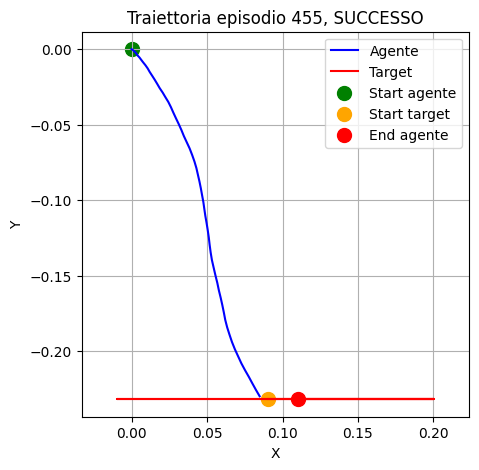

SUCCESSO Episode: 456, Step: 61, Counter: 271, Total reward: 609.8453369140625, final state: tensor([ 0.1429, -0.0859,  0.1541, -0.0906])
SUCCESSO Episode: 457, Step: 54, Counter: 272, Total reward: 546.383544921875, final state: tensor([ 0.1021, -0.0564,  0.1120, -0.0639])
SUCCESSO Episode: 460, Step: 89, Counter: 273, Total reward: 632.9014282226562, final state: tensor([ 0.3900, -0.0076,  0.3785, -0.0126])
Episode: 460, Step: 89, Counter: 273, Total reward: 632.9014282226562, final state: tensor([ 0.3900, -0.0076,  0.3785, -0.0126])
SUCCESSO Episode: 461, Step: 258, Counter: 274, Total reward: 430.1986999511719, final state: tensor([0.3466, 0.2872, 0.3346, 0.2999])
SUCCESSO Episode: 462, Step: 181, Counter: 275, Total reward: 728.9833374023438, final state: tensor([-0.0177, -0.4887, -0.0048, -0.4775])
SUCCESSO Episode: 463, Step: 87, Counter: 276, Total reward: 552.72509765625, final state: tensor([-0.2282,  0.0337, -0.2413,  0.0416])
SUCCESSO Episode: 464, Step: 62, Counter: 277, T

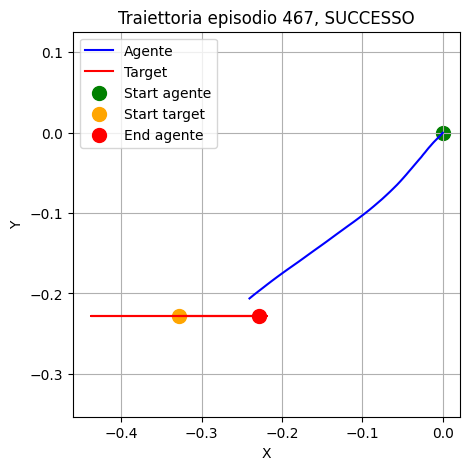

SUCCESSO Episode: 468, Step: 153, Counter: 281, Total reward: 632.0968017578125, final state: tensor([-0.4847,  0.4261, -0.4716,  0.4143])
SUCCESSO Episode: 469, Step: 115, Counter: 282, Total reward: 633.4120483398438, final state: tensor([-0.4479,  0.0852, -0.4322,  0.0765])
SUCCESSO Episode: 470, Step: 86, Counter: 283, Total reward: 560.1875, final state: tensor([-0.2050,  0.0380, -0.2059,  0.0542])
Episode: 470, Step: 86, Counter: 283, Total reward: 560.1875, final state: tensor([-0.2050,  0.0380, -0.2059,  0.0542])
SUCCESSO Episode: 471, Step: 144, Counter: 284, Total reward: 652.743408203125, final state: tensor([0.1787, 0.3443, 0.1914, 0.3297])
SUCCESSO Episode: 472, Step: 311, Counter: 285, Total reward: 535.6422119140625, final state: tensor([-0.2508, -0.4769, -0.2636, -0.4890])
SUCCESSO Episode: 473, Step: 88, Counter: 286, Total reward: 647.0769653320312, final state: tensor([-0.3549,  0.3839, -0.3631,  0.4000])
SUCCESSO Episode: 474, Step: 93, Counter: 287, Total reward: 6

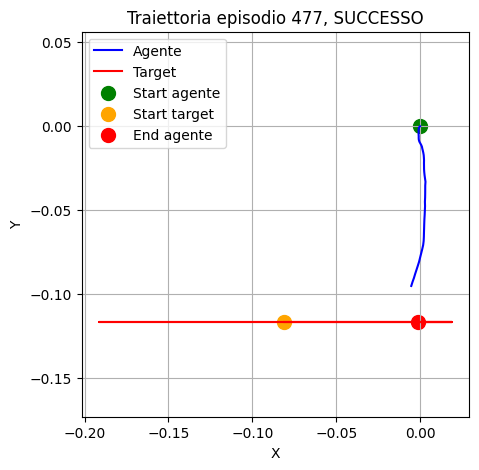

SUCCESSO Episode: 478, Step: 196, Counter: 291, Total reward: 817.45068359375, final state: tensor([ 0.0266, -0.4433,  0.0389, -0.4530])
SUCCESSO Episode: 479, Step: 83, Counter: 292, Total reward: 667.1812744140625, final state: tensor([-0.3772,  0.2530, -0.3837,  0.2380])
SUCCESSO Episode: 480, Step: 113, Counter: 293, Total reward: 691.4334716796875, final state: tensor([-0.4980,  0.1018, -0.4872,  0.1032])
Episode: 480, Step: 113, Counter: 293, Total reward: 691.4334716796875, final state: tensor([-0.4980,  0.1018, -0.4872,  0.1032])
SUCCESSO Episode: 481, Step: 54, Counter: 294, Total reward: 602.356201171875, final state: tensor([-0.1458, -0.1064, -0.1547, -0.1107])
SUCCESSO Episode: 482, Step: 162, Counter: 295, Total reward: 573.9154052734375, final state: tensor([-0.1740, -0.1511, -0.1913, -0.1443])
SUCCESSO Episode: 484, Step: 58, Counter: 296, Total reward: 582.317138671875, final state: tensor([ 0.1166, -0.0103,  0.1264, -0.0239])
SUCCESSO Episode: 485, Step: 142, Counter: 

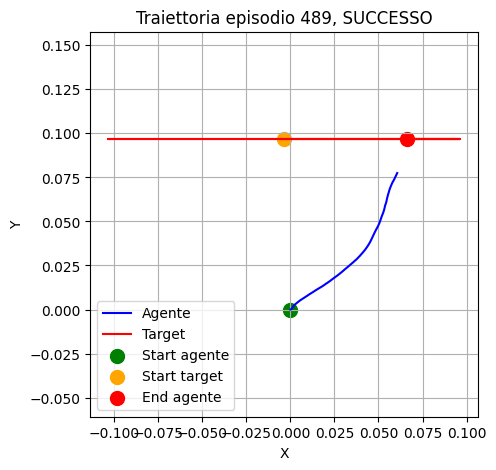

SUCCESSO Episode: 490, Step: 146, Counter: 301, Total reward: 642.4439086914062, final state: tensor([-0.1643,  0.2905, -0.1658,  0.2709])
Episode: 490, Step: 146, Counter: 301, Total reward: 642.4439086914062, final state: tensor([-0.1643,  0.2905, -0.1658,  0.2709])
SUCCESSO Episode: 491, Step: 150, Counter: 302, Total reward: 773.161865234375, final state: tensor([-0.3563, -0.4418, -0.3534, -0.4249])
SUCCESSO Episode: 492, Step: 33, Counter: 303, Total reward: 604.8639526367188, final state: tensor([ 0.1097,  0.0107,  0.1182, -0.0045])
SUCCESSO Episode: 493, Step: 58, Counter: 304, Total reward: 630.8330688476562, final state: tensor([ 0.1941, -0.0673,  0.2084, -0.0652])
SUCCESSO Episode: 494, Step: 88, Counter: 305, Total reward: 661.1719970703125, final state: tensor([-0.2504,  0.3382, -0.2536,  0.3191])
SUCCESSO Episode: 495, Step: 65, Counter: 306, Total reward: 618.0695190429688, final state: tensor([0.3005, 0.1994, 0.3094, 0.1947])
SUCCESSO Episode: 496, Step: 86, Counter: 307

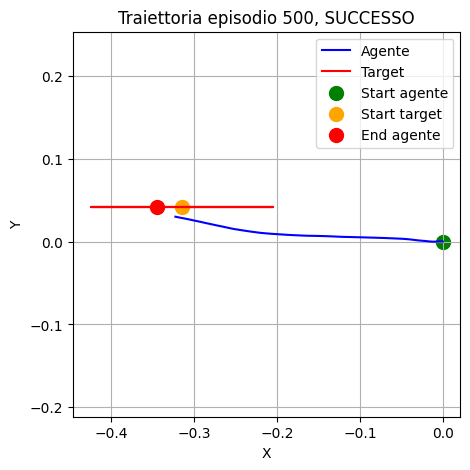

Episode: 500, Step: 86, Counter: 310, Total reward: 636.9955444335938, final state: tensor([-0.3255,  0.0305, -0.3349,  0.0419])
SUCCESSO Episode: 501, Step: 67, Counter: 311, Total reward: 648.1253051757812, final state: tensor([0.3484, 0.2193, 0.3629, 0.2322])
SUCCESSO Episode: 502, Step: 63, Counter: 312, Total reward: 634.419677734375, final state: tensor([0.3275, 0.1473, 0.3366, 0.1588])
SUCCESSO Episode: 503, Step: 129, Counter: 313, Total reward: 652.4853515625, final state: tensor([0.2301, 0.3563, 0.2223, 0.3492])
SUCCESSO Episode: 504, Step: 53, Counter: 314, Total reward: 616.254150390625, final state: tensor([-0.1518, -0.0168, -0.1603, -0.0106])
SUCCESSO Episode: 505, Step: 149, Counter: 315, Total reward: 673.7255859375, final state: tensor([-0.2375,  0.4955, -0.2288,  0.4877])
SUCCESSO Episode: 507, Step: 128, Counter: 316, Total reward: 680.924560546875, final state: tensor([0.2290, 0.4381, 0.2256, 0.4252])
SUCCESSO Episode: 508, Step: 89, Counter: 317, Total reward: 599.

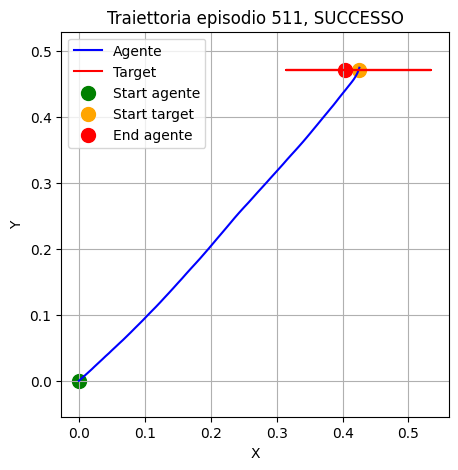

SUCCESSO Episode: 512, Step: 66, Counter: 321, Total reward: 653.637939453125, final state: tensor([ 0.3976, -0.0128,  0.4043, -0.0258])
SUCCESSO Episode: 513, Step: 92, Counter: 322, Total reward: 661.1564331054688, final state: tensor([0.4123, 0.3547, 0.4020, 0.3445])
SUCCESSO Episode: 514, Step: 148, Counter: 323, Total reward: 701.3509521484375, final state: tensor([-0.2004,  0.3465, -0.2009,  0.3289])
SUCCESSO Episode: 515, Step: 85, Counter: 324, Total reward: 714.71435546875, final state: tensor([-0.4575,  0.0785, -0.4530,  0.0963])
SUCCESSO Episode: 516, Step: 150, Counter: 325, Total reward: 798.5494384765625, final state: tensor([-0.2418, -0.3947, -0.2300, -0.3794])
SUCCESSO Episode: 517, Step: 86, Counter: 326, Total reward: 705.515625, final state: tensor([-0.4388,  0.1874, -0.4430,  0.1963])
SUCCESSO Episode: 518, Step: 161, Counter: 327, Total reward: 651.5850219726562, final state: tensor([-0.1427,  0.2374, -0.1501,  0.2248])
SUCCESSO Episode: 519, Step: 130, Counter: 32

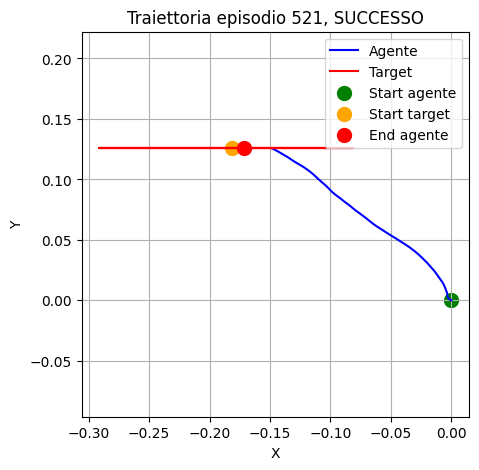

SUCCESSO Episode: 522, Step: 67, Counter: 331, Total reward: 649.2252807617188, final state: tensor([0.3595, 0.1214, 0.3760, 0.1159])
SUCCESSO Episode: 523, Step: 267, Counter: 332, Total reward: 703.6006469726562, final state: tensor([-0.2234, -0.4662, -0.2370, -0.4756])
SUCCESSO Episode: 525, Step: 66, Counter: 333, Total reward: 650.7916259765625, final state: tensor([0.3578, 0.0221, 0.3747, 0.0289])
SUCCESSO Episode: 526, Step: 89, Counter: 334, Total reward: 638.068115234375, final state: tensor([0.4542, 0.2842, 0.4491, 0.2988])
SUCCESSO Episode: 527, Step: 79, Counter: 335, Total reward: 710.587890625, final state: tensor([ 0.4679, -0.1484,  0.4479, -0.1493])
SUCCESSO Episode: 528, Step: 65, Counter: 336, Total reward: 654.1954345703125, final state: tensor([ 0.2695, -0.0931,  0.2772, -0.0981])
SUCCESSO Episode: 529, Step: 60, Counter: 337, Total reward: 600.3382568359375, final state: tensor([0.0297, 0.1234, 0.0399, 0.1275])
SUCCESSO Episode: 530, Step: 90, Counter: 338, Total r

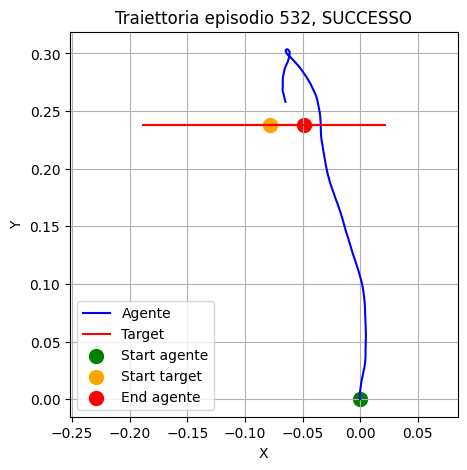

SUCCESSO Episode: 533, Step: 238, Counter: 341, Total reward: 786.2596435546875, final state: tensor([-0.2237, -0.3707, -0.2212, -0.3895])
SUCCESSO Episode: 534, Step: 54, Counter: 342, Total reward: 643.5703125, final state: tensor([-0.0750, -0.1963, -0.0654, -0.2128])
SUCCESSO Episode: 535, Step: 162, Counter: 343, Total reward: 791.8466796875, final state: tensor([-0.1672, -0.2722, -0.1837, -0.2664])
SUCCESSO Episode: 536, Step: 150, Counter: 344, Total reward: 816.19970703125, final state: tensor([-0.4323, -0.4721, -0.4179, -0.4821])
SUCCESSO Episode: 537, Step: 81, Counter: 345, Total reward: 681.6441650390625, final state: tensor([ 0.4719, -0.0860,  0.4577, -0.0722])
SUCCESSO Episode: 538, Step: 160, Counter: 346, Total reward: 627.22607421875, final state: tensor([-0.1027,  0.1827, -0.1157,  0.1796])
SUCCESSO Episode: 539, Step: 89, Counter: 347, Total reward: 710.9839477539062, final state: tensor([-0.2613,  0.4521, -0.2717,  0.4500])
Episode: 540, Step: 400, Counter: 347, Tota

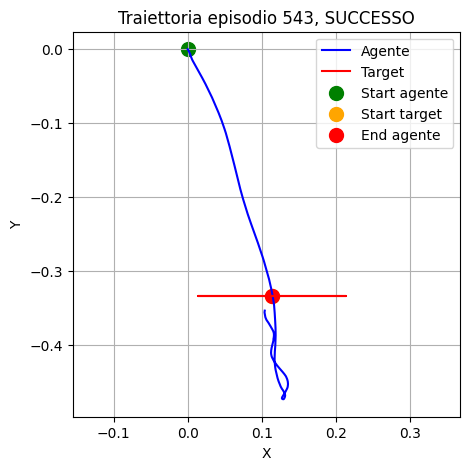

SUCCESSO Episode: 544, Step: 78, Counter: 351, Total reward: 731.535400390625, final state: tensor([ 0.4474, -0.2649,  0.4312, -0.2683])
SUCCESSO Episode: 545, Step: 66, Counter: 352, Total reward: 647.1700439453125, final state: tensor([0.4301, 0.1344, 0.4427, 0.1496])
SUCCESSO Episode: 546, Step: 26, Counter: 353, Total reward: 563.8011474609375, final state: tensor([0.0554, 0.0037, 0.0677, 0.0127])
SUCCESSO Episode: 547, Step: 150, Counter: 354, Total reward: 808.6177978515625, final state: tensor([-0.2349, -0.3404, -0.2293, -0.3235])
SUCCESSO Episode: 548, Step: 151, Counter: 355, Total reward: 750.0096435546875, final state: tensor([-0.2544, -0.3307, -0.2495, -0.3136])
SUCCESSO Episode: 549, Step: 67, Counter: 356, Total reward: 673.4481811523438, final state: tensor([ 0.2569, -0.1547,  0.2696, -0.1499])
SUCCESSO Episode: 550, Step: 108, Counter: 357, Total reward: 716.3303833007812, final state: tensor([-0.4775,  0.4730, -0.4622,  0.4691])
Episode: 550, Step: 108, Counter: 357, T

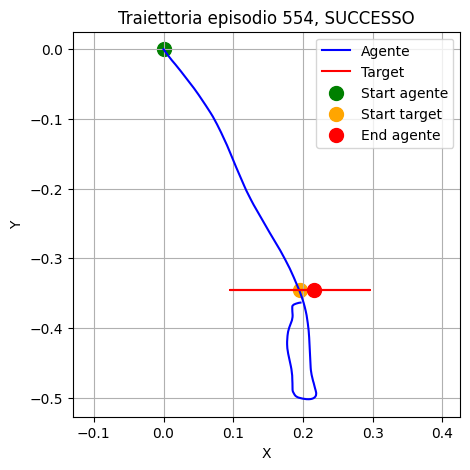

SUCCESSO Episode: 555, Step: 68, Counter: 361, Total reward: 695.8995361328125, final state: tensor([ 0.2841, -0.2601,  0.2958, -0.2756])
SUCCESSO Episode: 556, Step: 88, Counter: 362, Total reward: 640.2770385742188, final state: tensor([-0.2753,  0.0221, -0.2762,  0.0370])
SUCCESSO Episode: 558, Step: 88, Counter: 363, Total reward: 728.7103271484375, final state: tensor([-0.3956,  0.3670, -0.4085,  0.3775])
SUCCESSO Episode: 559, Step: 173, Counter: 364, Total reward: 840.9400634765625, final state: tensor([-0.1682, -0.3614, -0.1844, -0.3705])
SUCCESSO Episode: 560, Step: 105, Counter: 365, Total reward: 633.8753662109375, final state: tensor([0.4263, 0.4434, 0.4387, 0.4557])
Episode: 560, Step: 105, Counter: 365, Total reward: 633.8753662109375, final state: tensor([0.4263, 0.4434, 0.4387, 0.4557])
SUCCESSO Episode: 561, Step: 92, Counter: 366, Total reward: 691.9885864257812, final state: tensor([0.4148, 0.3048, 0.4021, 0.3095])
SUCCESSO Episode: 562, Step: 57, Counter: 367, Total

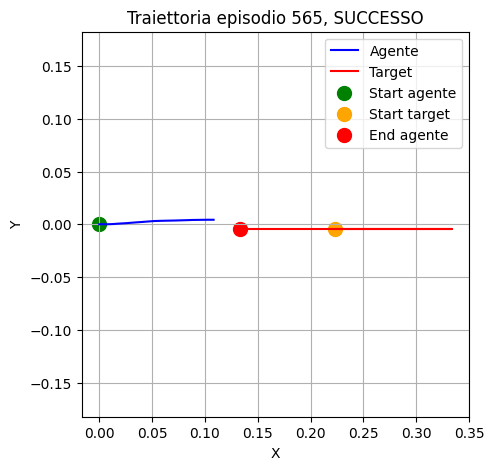

SUCCESSO Episode: 566, Step: 144, Counter: 371, Total reward: 746.2767944335938, final state: tensor([-0.3876, -0.2784, -0.3790, -0.2798])
SUCCESSO Episode: 567, Step: 221, Counter: 372, Total reward: 824.7625732421875, final state: tensor([ 0.1644, -0.4352,  0.1733, -0.4239])
SUCCESSO Episode: 568, Step: 66, Counter: 373, Total reward: 656.4049682617188, final state: tensor([ 0.3375, -0.0049,  0.3512, -0.0049])
SUCCESSO Episode: 569, Step: 62, Counter: 374, Total reward: 631.5969848632812, final state: tensor([0.0160, 0.0737, 0.0206, 0.0924])
SUCCESSO Episode: 570, Step: 68, Counter: 375, Total reward: 679.0390625, final state: tensor([ 0.2985, -0.1442,  0.3047, -0.1522])
Episode: 570, Step: 68, Counter: 375, Total reward: 679.0390625, final state: tensor([ 0.2985, -0.1442,  0.3047, -0.1522])
SUCCESSO Episode: 571, Step: 60, Counter: 376, Total reward: 620.5463256835938, final state: tensor([0.2118, 0.0572, 0.2180, 0.0657])
SUCCESSO Episode: 572, Step: 86, Counter: 377, Total reward: 

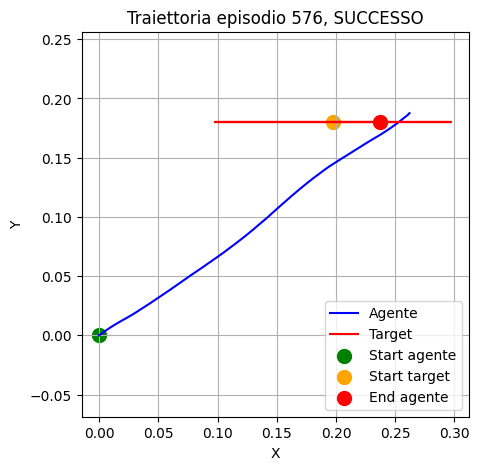

SUCCESSO Episode: 577, Step: 93, Counter: 381, Total reward: 639.878173828125, final state: tensor([0.2232, 0.2608, 0.2086, 0.2527])
SUCCESSO Episode: 578, Step: 86, Counter: 382, Total reward: 730.64013671875, final state: tensor([-0.3440,  0.3824, -0.3614,  0.3809])
Episode: 580, Step: 400, Counter: 382, Total reward: 199.88018798828125, final state: tensor([ 0.2648, -0.4308,  0.3658, -0.3711])
SUCCESSO Episode: 581, Step: 82, Counter: 383, Total reward: 681.779052734375, final state: tensor([-0.1760,  0.2568, -0.1849,  0.2435])
SUCCESSO Episode: 582, Step: 83, Counter: 384, Total reward: 727.0574951171875, final state: tensor([-0.3709,  0.3222, -0.3892,  0.3180])
SUCCESSO Episode: 583, Step: 66, Counter: 385, Total reward: 634.962158203125, final state: tensor([ 0.3219, -0.0014,  0.3321,  0.0075])
SUCCESSO Episode: 584, Step: 147, Counter: 386, Total reward: 815.5784912109375, final state: tensor([-0.5022, -0.2152, -0.4836, -0.2130])
SUCCESSO Episode: 585, Step: 84, Counter: 387, To

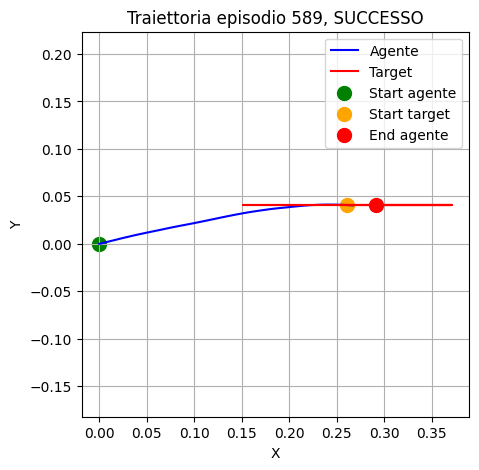

SUCCESSO Episode: 590, Step: 78, Counter: 391, Total reward: 681.5859375, final state: tensor([ 0.4190, -0.1687,  0.4030, -0.1581])
Episode: 590, Step: 78, Counter: 391, Total reward: 681.5859375, final state: tensor([ 0.4190, -0.1687,  0.4030, -0.1581])
SUCCESSO Episode: 591, Step: 86, Counter: 392, Total reward: 685.431884765625, final state: tensor([0.1645, 0.4398, 0.1526, 0.4320])
SUCCESSO Episode: 592, Step: 87, Counter: 393, Total reward: 724.7758178710938, final state: tensor([-0.4092,  0.4241, -0.4075,  0.4372])
SUCCESSO Episode: 593, Step: 220, Counter: 394, Total reward: 902.0250854492188, final state: tensor([ 0.1691, -0.4381,  0.1879, -0.4322])
SUCCESSO Episode: 594, Step: 80, Counter: 395, Total reward: 688.7777709960938, final state: tensor([-0.1985,  0.2278, -0.1990,  0.2082])
SUCCESSO Episode: 595, Step: 83, Counter: 396, Total reward: 740.027587890625, final state: tensor([-0.4681,  0.0705, -0.4826,  0.0822])
SUCCESSO Episode: 596, Step: 80, Counter: 397, Total reward:

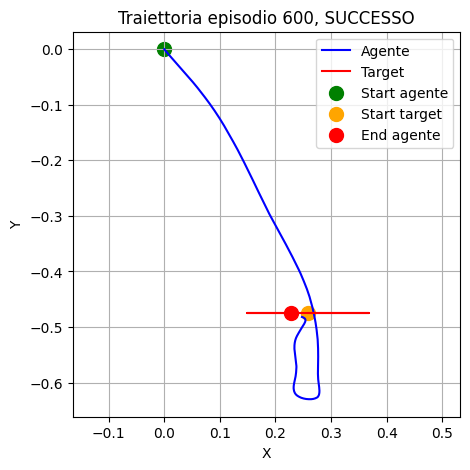

Episode: 600, Step: 218, Counter: 400, Total reward: 914.5101318359375, final state: tensor([ 0.2465, -0.4817,  0.2383, -0.4754])
SUCCESSO Episode: 601, Step: 125, Counter: 401, Total reward: 721.7958984375, final state: tensor([-0.5367, -0.1926, -0.5479, -0.1764])
SUCCESSO Episode: 602, Step: 125, Counter: 402, Total reward: 734.5554809570312, final state: tensor([0.0342, 0.2895, 0.0386, 0.2704])
SUCCESSO Episode: 603, Step: 59, Counter: 403, Total reward: 674.9987182617188, final state: tensor([ 0.1806, -0.0404,  0.1933, -0.0541])
SUCCESSO Episode: 604, Step: 84, Counter: 404, Total reward: 720.224853515625, final state: tensor([-0.2130,  0.4849, -0.2264,  0.4971])
SUCCESSO Episode: 605, Step: 46, Counter: 405, Total reward: 588.8356323242188, final state: tensor([-0.0222, -0.0410, -0.0338, -0.0486])
SUCCESSO Episode: 606, Step: 84, Counter: 406, Total reward: 741.1627807617188, final state: tensor([-0.3674,  0.2979, -0.3764,  0.2948])
SUCCESSO Episode: 607, Step: 64, Counter: 407, T

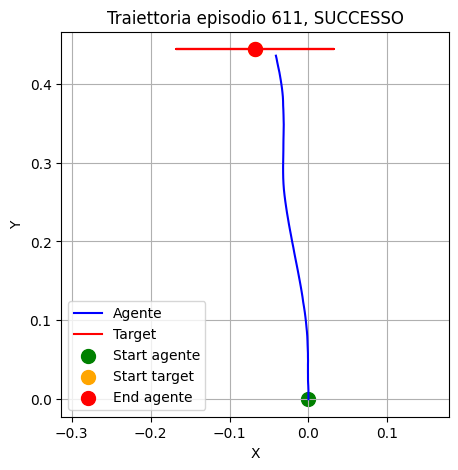

SUCCESSO Episode: 612, Step: 136, Counter: 411, Total reward: 684.74365234375, final state: tensor([-0.0500,  0.1479, -0.0403,  0.1385])
SUCCESSO Episode: 613, Step: 165, Counter: 412, Total reward: 783.21240234375, final state: tensor([-0.0499, -0.2436, -0.0524, -0.2258])
SUCCESSO Episode: 616, Step: 270, Counter: 413, Total reward: 714.3717651367188, final state: tensor([-0.2196, -0.4520, -0.2269, -0.4689])
SUCCESSO Episode: 617, Step: 62, Counter: 414, Total reward: 673.153076171875, final state: tensor([ 0.1529, -0.1255,  0.1717, -0.1315])
SUCCESSO Episode: 618, Step: 68, Counter: 415, Total reward: 676.0928955078125, final state: tensor([ 0.3410, -0.0121,  0.3444, -0.0268])
SUCCESSO Episode: 620, Step: 91, Counter: 416, Total reward: 718.5349731445312, final state: tensor([0.4138, 0.2783, 0.3986, 0.2766])
Episode: 620, Step: 91, Counter: 416, Total reward: 718.5349731445312, final state: tensor([0.4138, 0.2783, 0.3986, 0.2766])
SUCCESSO Episode: 621, Step: 90, Counter: 417, Total 

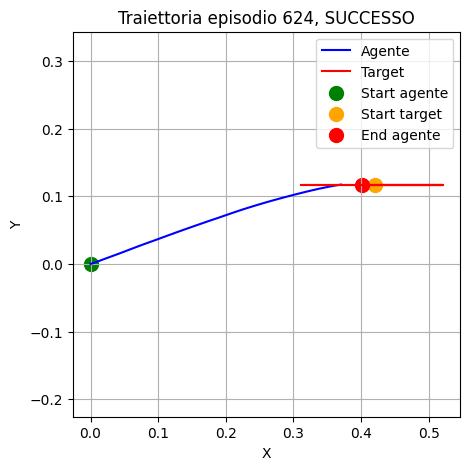

SUCCESSO Episode: 625, Step: 64, Counter: 421, Total reward: 642.07421875, final state: tensor([ 0.3012, -0.0146,  0.3165, -0.0185])
SUCCESSO Episode: 626, Step: 135, Counter: 422, Total reward: 749.1097412109375, final state: tensor([-0.3591, -0.3936, -0.3527, -0.3748])
SUCCESSO Episode: 627, Step: 61, Counter: 423, Total reward: 677.3555297851562, final state: tensor([ 0.2017, -0.0616,  0.2156, -0.0697])
SUCCESSO Episode: 628, Step: 54, Counter: 424, Total reward: 653.005126953125, final state: tensor([-0.1983, -0.0257, -0.1995, -0.0084])
SUCCESSO Episode: 629, Step: 114, Counter: 425, Total reward: 744.844970703125, final state: tensor([-0.5289,  0.0959, -0.5158,  0.0820])
SUCCESSO Episode: 630, Step: 83, Counter: 426, Total reward: 709.2276611328125, final state: tensor([-0.2701,  0.3121, -0.2810,  0.2976])
Episode: 630, Step: 83, Counter: 426, Total reward: 709.2276611328125, final state: tensor([-0.2701,  0.3121, -0.2810,  0.2976])
SUCCESSO Episode: 631, Step: 49, Counter: 427, T

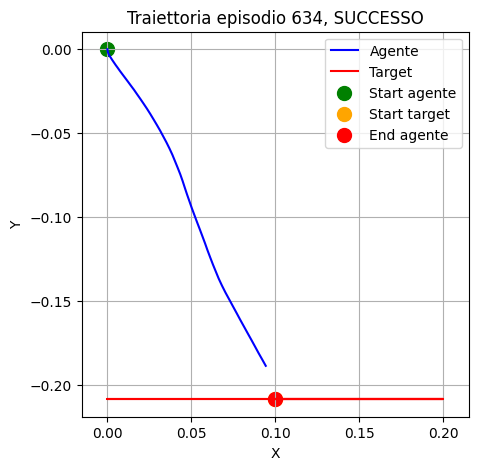

SUCCESSO Episode: 635, Step: 82, Counter: 431, Total reward: 654.979736328125, final state: tensor([0.2320, 0.3662, 0.2150, 0.3601])
SUCCESSO Episode: 636, Step: 216, Counter: 432, Total reward: 905.7288818359375, final state: tensor([ 0.2534, -0.4667,  0.2399, -0.4604])
SUCCESSO Episode: 637, Step: 201, Counter: 433, Total reward: 910.6776123046875, final state: tensor([ 0.0034, -0.3959, -0.0095, -0.3951])
SUCCESSO Episode: 638, Step: 86, Counter: 434, Total reward: 716.3313598632812, final state: tensor([-0.2799,  0.4711, -0.2780,  0.4867])
SUCCESSO Episode: 639, Step: 116, Counter: 435, Total reward: 750.004150390625, final state: tensor([-0.4343, -0.0039, -0.4175, -0.0011])
SUCCESSO Episode: 640, Step: 63, Counter: 436, Total reward: 699.1617431640625, final state: tensor([0.1244, 0.1874, 0.1282, 0.2025])
Episode: 640, Step: 63, Counter: 436, Total reward: 699.1617431640625, final state: tensor([0.1244, 0.1874, 0.1282, 0.2025])
SUCCESSO Episode: 641, Step: 176, Counter: 437, Total 

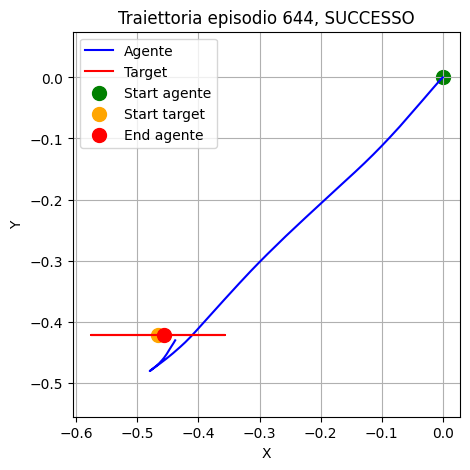

SUCCESSO Episode: 645, Step: 171, Counter: 441, Total reward: 856.1461181640625, final state: tensor([-0.0539, -0.3711, -0.0731, -0.3673])
SUCCESSO Episode: 646, Step: 60, Counter: 442, Total reward: 689.2864379882812, final state: tensor([0.0674, 0.1758, 0.0675, 0.1895])
SUCCESSO Episode: 647, Step: 201, Counter: 443, Total reward: 866.3780517578125, final state: tensor([ 0.2603, -0.3158,  0.2706, -0.2998])
SUCCESSO Episode: 648, Step: 147, Counter: 444, Total reward: 775.01904296875, final state: tensor([-0.2751, -0.3922, -0.2625, -0.3954])
SUCCESSO Episode: 649, Step: 62, Counter: 445, Total reward: 667.2384033203125, final state: tensor([0.1590, 0.1888, 0.1564, 0.2065])
Episode: 650, Step: 400, Counter: 445, Total reward: 74.53329467773438, final state: tensor([-0.5421,  0.3693, -0.4284,  0.4362])
SUCCESSO Episode: 651, Step: 119, Counter: 446, Total reward: 812.0525512695312, final state: tensor([-0.5527,  0.0499, -0.5380,  0.0413])
SUCCESSO Episode: 652, Step: 86, Counter: 447, T

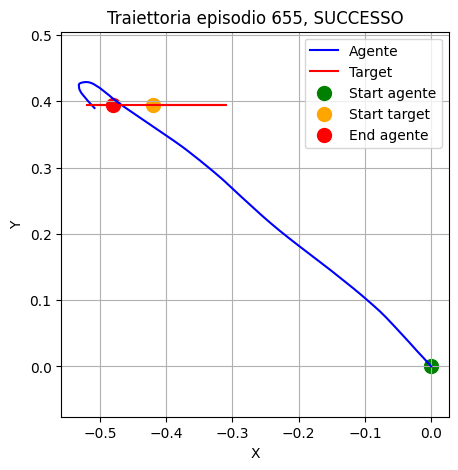

SUCCESSO Episode: 656, Step: 139, Counter: 451, Total reward: 769.968017578125, final state: tensor([0.0457, 0.3085, 0.0576, 0.3173])
SUCCESSO Episode: 657, Step: 60, Counter: 452, Total reward: 675.646728515625, final state: tensor([-0.0380,  0.1279, -0.0277,  0.1436])
SUCCESSO Episode: 658, Step: 138, Counter: 453, Total reward: 758.34619140625, final state: tensor([0.0339, 0.2324, 0.0464, 0.2316])
SUCCESSO Episode: 659, Step: 141, Counter: 454, Total reward: 774.921875, final state: tensor([-0.3584, -0.4341, -0.3484, -0.4396])
SUCCESSO Episode: 660, Step: 149, Counter: 455, Total reward: 810.5650634765625, final state: tensor([-0.2160, -0.3395, -0.2029, -0.3405])
Episode: 660, Step: 149, Counter: 455, Total reward: 810.5650634765625, final state: tensor([-0.2160, -0.3395, -0.2029, -0.3405])
SUCCESSO Episode: 661, Step: 203, Counter: 456, Total reward: 799.9798583984375, final state: tensor([ 0.3131, -0.2961,  0.3218, -0.2808])
SUCCESSO Episode: 662, Step: 80, Counter: 457, Total rew

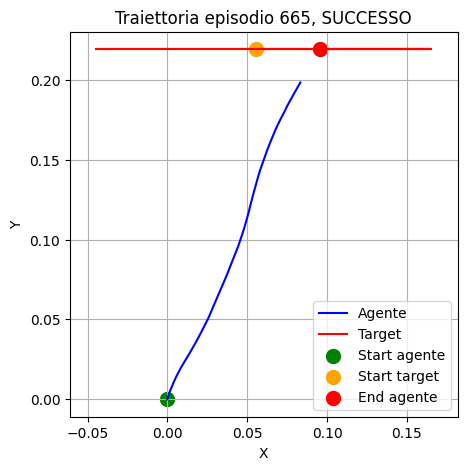

SUCCESSO Episode: 666, Step: 87, Counter: 461, Total reward: 739.8648071289062, final state: tensor([-0.2735,  0.4855, -0.2815,  0.4963])
SUCCESSO Episode: 667, Step: 68, Counter: 462, Total reward: 692.1815185546875, final state: tensor([0.4390, 0.1513, 0.4548, 0.1503])
SUCCESSO Episode: 668, Step: 83, Counter: 463, Total reward: 723.2225341796875, final state: tensor([-0.3362,  0.1749, -0.3505,  0.1802])
SUCCESSO Episode: 669, Step: 135, Counter: 464, Total reward: 706.966552734375, final state: tensor([-0.3807, -0.4783, -0.3978, -0.4693])
SUCCESSO Episode: 670, Step: 53, Counter: 465, Total reward: 646.9929809570312, final state: tensor([-0.1475, -0.0471, -0.1523, -0.0374])
Episode: 670, Step: 53, Counter: 465, Total reward: 646.9929809570312, final state: tensor([-0.1475, -0.0471, -0.1523, -0.0374])
SUCCESSO Episode: 671, Step: 92, Counter: 466, Total reward: 692.175537109375, final state: tensor([0.4243, 0.2278, 0.4083, 0.2272])
SUCCESSO Episode: 672, Step: 62, Counter: 467, Total

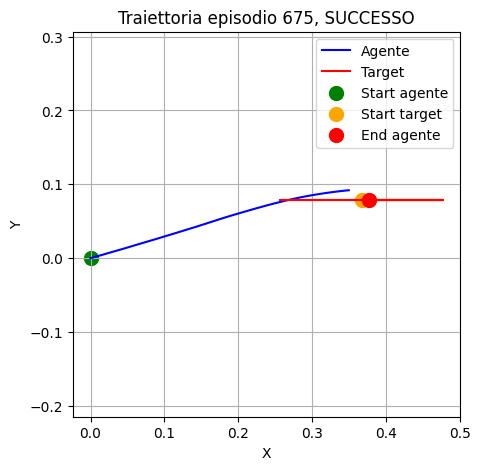

SUCCESSO Episode: 676, Step: 140, Counter: 471, Total reward: 788.087158203125, final state: tensor([-0.0713,  0.2407, -0.0614,  0.2253])
SUCCESSO Episode: 677, Step: 125, Counter: 472, Total reward: 761.62744140625, final state: tensor([-0.0181,  0.3871, -0.0233,  0.3734])
SUCCESSO Episode: 679, Step: 80, Counter: 473, Total reward: 682.6981811523438, final state: tensor([-0.2158,  0.0859, -0.2232,  0.0924])
SUCCESSO Episode: 680, Step: 79, Counter: 474, Total reward: 737.5850830078125, final state: tensor([ 0.3732, -0.2805,  0.3624, -0.2893])
Episode: 680, Step: 79, Counter: 474, Total reward: 737.5850830078125, final state: tensor([ 0.3732, -0.2805,  0.3624, -0.2893])
SUCCESSO Episode: 681, Step: 58, Counter: 475, Total reward: 683.3380737304688, final state: tensor([0.1253, 0.1307, 0.1430, 0.1316])
SUCCESSO Episode: 682, Step: 200, Counter: 476, Total reward: 914.14208984375, final state: tensor([ 0.1975, -0.3681,  0.2131, -0.3684])
SUCCESSO Episode: 683, Step: 88, Counter: 477, To

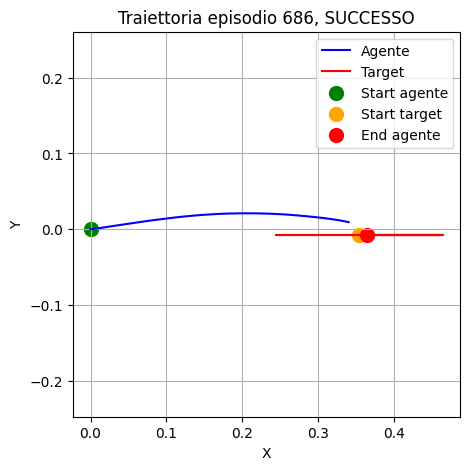

SUCCESSO Episode: 687, Step: 85, Counter: 481, Total reward: 734.30322265625, final state: tensor([-0.2751,  0.3696, -0.2828,  0.3707])
SUCCESSO Episode: 688, Step: 5, Counter: 482, Total reward: 487.7049560546875, final state: tensor([ 2.3558e-04,  7.2286e-05, -4.6947e-03,  1.4817e-02])
SUCCESSO Episode: 689, Step: 81, Counter: 483, Total reward: 710.7239990234375, final state: tensor([-0.1615,  0.0939, -0.1708,  0.0930])
SUCCESSO Episode: 690, Step: 54, Counter: 484, Total reward: 657.6048583984375, final state: tensor([-0.2313, -0.1100, -0.2365, -0.1089])
Episode: 690, Step: 54, Counter: 484, Total reward: 657.6048583984375, final state: tensor([-0.2313, -0.1100, -0.2365, -0.1089])
SUCCESSO Episode: 691, Step: 80, Counter: 485, Total reward: 743.0125732421875, final state: tensor([ 0.4366, -0.2328,  0.4294, -0.2419])
SUCCESSO Episode: 692, Step: 62, Counter: 486, Total reward: 697.2457275390625, final state: tensor([ 0.1628, -0.1622,  0.1767, -0.1748])
SUCCESSO Episode: 693, Step: 1

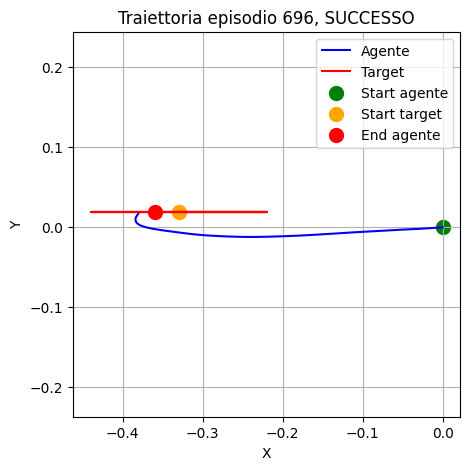

SUCCESSO Episode: 697, Step: 83, Counter: 491, Total reward: 735.8818359375, final state: tensor([-0.1656,  0.3342, -0.1730,  0.3289])
SUCCESSO Episode: 698, Step: 170, Counter: 492, Total reward: 877.8265380859375, final state: tensor([-0.0403, -0.2641, -0.0491, -0.2513])
SUCCESSO Episode: 699, Step: 130, Counter: 493, Total reward: 741.1424560546875, final state: tensor([0.1681, 0.2000, 0.1571, 0.2068])
SUCCESSO Episode: 700, Step: 133, Counter: 494, Total reward: 754.9390258789062, final state: tensor([-0.3187, -0.3485, -0.3230, -0.3324])
Episode: 700, Step: 133, Counter: 494, Total reward: 754.9390258789062, final state: tensor([-0.3187, -0.3485, -0.3230, -0.3324])
SUCCESSO Episode: 701, Step: 170, Counter: 495, Total reward: 891.0599975585938, final state: tensor([-0.5161,  0.2508, -0.5233,  0.2364])
SUCCESSO Episode: 702, Step: 61, Counter: 496, Total reward: 676.959716796875, final state: tensor([ 0.1768, -0.0180,  0.1938, -0.0254])
SUCCESSO Episode: 703, Step: 92, Counter: 497,

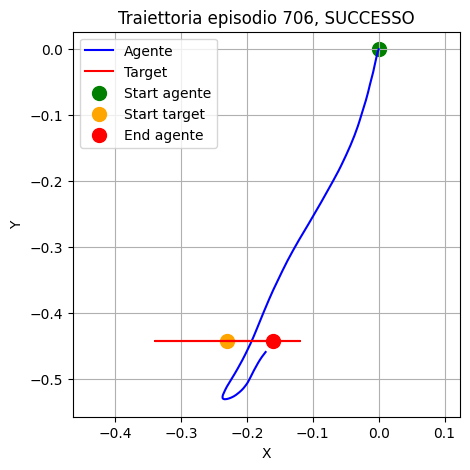

SUCCESSO Episode: 707, Step: 82, Counter: 501, Total reward: 702.8643798828125, final state: tensor([0.0663, 0.4292, 0.0512, 0.4366])
SUCCESSO Episode: 708, Step: 143, Counter: 502, Total reward: 783.3945922851562, final state: tensor([-0.4168, -0.3669, -0.4107, -0.3779])
SUCCESSO Episode: 709, Step: 84, Counter: 503, Total reward: 739.8212890625, final state: tensor([-0.0370,  0.4362, -0.0478,  0.4339])
SUCCESSO Episode: 710, Step: 49, Counter: 504, Total reward: 597.73193359375, final state: tensor([-0.0855, -0.0096, -0.0938,  0.0072])
Episode: 710, Step: 49, Counter: 504, Total reward: 597.73193359375, final state: tensor([-0.0855, -0.0096, -0.0938,  0.0072])
SUCCESSO Episode: 711, Step: 143, Counter: 505, Total reward: 770.479736328125, final state: tensor([-0.4200, -0.3396, -0.4084, -0.3517])
SUCCESSO Episode: 712, Step: 91, Counter: 506, Total reward: 691.7333984375, final state: tensor([0.5244, 0.4531, 0.5166, 0.4651])
SUCCESSO Episode: 714, Step: 130, Counter: 507, Total reward

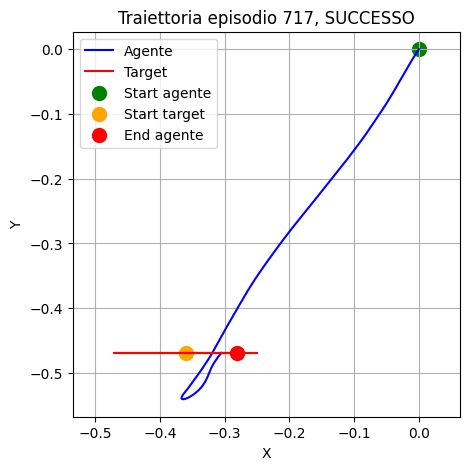

SUCCESSO Episode: 718, Step: 79, Counter: 511, Total reward: 718.784423828125, final state: tensor([-0.1843,  0.2017, -0.2021,  0.2047])
SUCCESSO Episode: 719, Step: 84, Counter: 512, Total reward: 739.64453125, final state: tensor([-0.3325,  0.1635, -0.3381,  0.1734])
SUCCESSO Episode: 720, Step: 82, Counter: 513, Total reward: 762.8413696289062, final state: tensor([ 0.4511, -0.3879,  0.4499, -0.4061])
Episode: 720, Step: 82, Counter: 513, Total reward: 762.8413696289062, final state: tensor([ 0.4511, -0.3879,  0.4499, -0.4061])
SUCCESSO Episode: 721, Step: 61, Counter: 514, Total reward: 672.3923950195312, final state: tensor([ 0.1945, -0.0484,  0.2026, -0.0562])
SUCCESSO Episode: 722, Step: 203, Counter: 515, Total reward: 847.5784912109375, final state: tensor([ 0.3117, -0.3333,  0.3181, -0.3229])
SUCCESSO Episode: 723, Step: 85, Counter: 516, Total reward: 673.6417236328125, final state: tensor([0.2525, 0.3544, 0.2426, 0.3381])
SUCCESSO Episode: 724, Step: 64, Counter: 517, Total

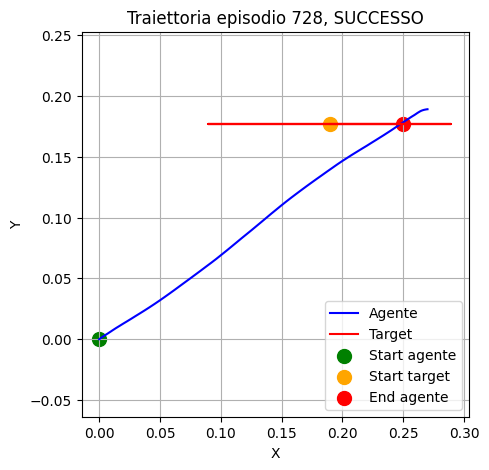

SUCCESSO Episode: 729, Step: 86, Counter: 521, Total reward: 751.98828125, final state: tensor([-0.2912,  0.1522, -0.3043,  0.1589])
SUCCESSO Episode: 730, Step: 82, Counter: 522, Total reward: 722.367431640625, final state: tensor([-0.1117,  0.1624, -0.1261,  0.1512])
Episode: 730, Step: 82, Counter: 522, Total reward: 722.367431640625, final state: tensor([-0.1117,  0.1624, -0.1261,  0.1512])
SUCCESSO Episode: 731, Step: 197, Counter: 523, Total reward: 886.253662109375, final state: tensor([-0.3886,  0.1714, -0.3834,  0.1578])
SUCCESSO Episode: 732, Step: 196, Counter: 524, Total reward: 782.207275390625, final state: tensor([ 0.4054, -0.4539,  0.4194, -0.4518])
SUCCESSO Episode: 733, Step: 86, Counter: 525, Total reward: 745.992431640625, final state: tensor([ 0.4726, -0.1046,  0.4572, -0.0931])
SUCCESSO Episode: 734, Step: 95, Counter: 526, Total reward: 728.33984375, final state: tensor([0.4545, 0.2807, 0.4408, 0.2824])
SUCCESSO Episode: 735, Step: 131, Counter: 527, Total reward

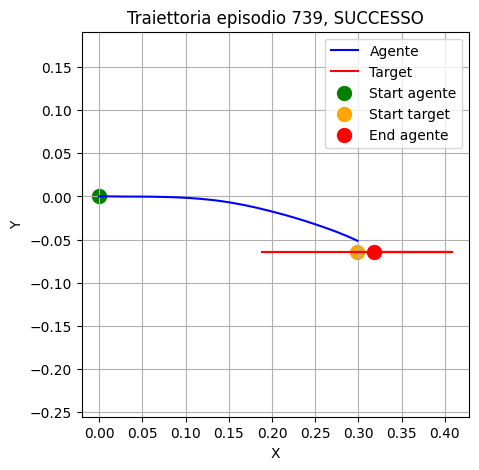

SUCCESSO Episode: 740, Step: 201, Counter: 531, Total reward: 941.5914306640625, final state: tensor([ 0.2734, -0.3794,  0.2878, -0.3798])
Episode: 740, Step: 201, Counter: 531, Total reward: 941.5914306640625, final state: tensor([ 0.2734, -0.3794,  0.2878, -0.3798])
SUCCESSO Episode: 741, Step: 170, Counter: 532, Total reward: 947.9716796875, final state: tensor([ 0.0753, -0.4970,  0.0645, -0.4942])
SUCCESSO Episode: 742, Step: 50, Counter: 533, Total reward: 646.3256225585938, final state: tensor([-0.0956, -0.1151, -0.0954, -0.1335])
SUCCESSO Episode: 743, Step: 81, Counter: 534, Total reward: 727.0523681640625, final state: tensor([-0.0915,  0.2124, -0.0938,  0.1955])
SUCCESSO Episode: 744, Step: 46, Counter: 535, Total reward: 619.95263671875, final state: tensor([-0.0538, -0.0438, -0.0714, -0.0513])
SUCCESSO Episode: 745, Step: 53, Counter: 536, Total reward: 647.736328125, final state: tensor([-0.1546, -0.1219, -0.1725, -0.1267])
SUCCESSO Episode: 746, Step: 148, Counter: 537, T

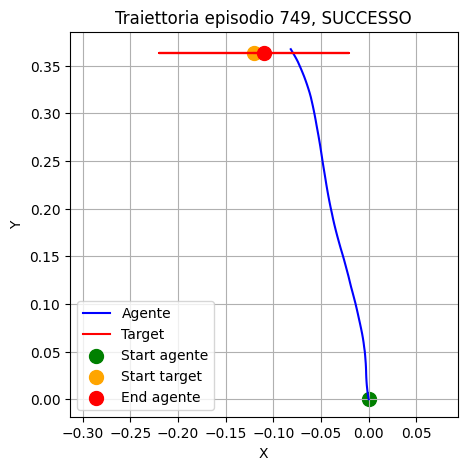

SUCCESSO Episode: 750, Step: 20, Counter: 541, Total reward: 563.0756225585938, final state: tensor([ 0.0199, -0.0026,  0.0191, -0.0208])
Episode: 750, Step: 20, Counter: 541, Total reward: 563.0756225585938, final state: tensor([ 0.0199, -0.0026,  0.0191, -0.0208])
SUCCESSO Episode: 751, Step: 128, Counter: 542, Total reward: 768.643310546875, final state: tensor([-0.5066, -0.1735, -0.5144, -0.1588])
SUCCESSO Episode: 752, Step: 48, Counter: 543, Total reward: 636.4244384765625, final state: tensor([-0.0538, -0.0831, -0.0598, -0.1012])
SUCCESSO Episode: 753, Step: 38, Counter: 544, Total reward: 547.8065185546875, final state: tensor([0.0696, 0.0199, 0.0602, 0.0336])
SUCCESSO Episode: 754, Step: 131, Counter: 545, Total reward: 741.9359130859375, final state: tensor([0.1689, 0.2643, 0.1579, 0.2649])
SUCCESSO Episode: 755, Step: 94, Counter: 546, Total reward: 741.2284545898438, final state: tensor([0.3882, 0.2207, 0.3730, 0.2181])
SUCCESSO Episode: 756, Step: 86, Counter: 547, Total r

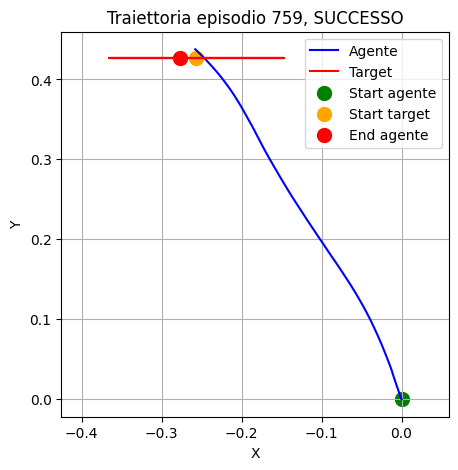

SUCCESSO Episode: 760, Step: 85, Counter: 551, Total reward: 757.9130859375, final state: tensor([-0.4260,  0.4181, -0.4297,  0.4344])
Episode: 760, Step: 85, Counter: 551, Total reward: 757.9130859375, final state: tensor([-0.4260,  0.4181, -0.4297,  0.4344])
SUCCESSO Episode: 761, Step: 172, Counter: 552, Total reward: 900.385498046875, final state: tensor([-0.1012, -0.3818, -0.1084, -0.3986])
SUCCESSO Episode: 762, Step: 171, Counter: 553, Total reward: 858.8592529296875, final state: tensor([ 0.0177, -0.2627,  0.0159, -0.2432])
SUCCESSO Episode: 763, Step: 136, Counter: 554, Total reward: 783.5997314453125, final state: tensor([-0.1836, -0.2063, -0.1751, -0.1927])
SUCCESSO Episode: 764, Step: 63, Counter: 555, Total reward: 668.7876586914062, final state: tensor([0.3250, 0.0574, 0.3330, 0.0392])
SUCCESSO Episode: 765, Step: 83, Counter: 556, Total reward: 694.2138671875, final state: tensor([-0.1895,  0.1198, -0.1987,  0.1103])
SUCCESSO Episode: 766, Step: 192, Counter: 557, Total 

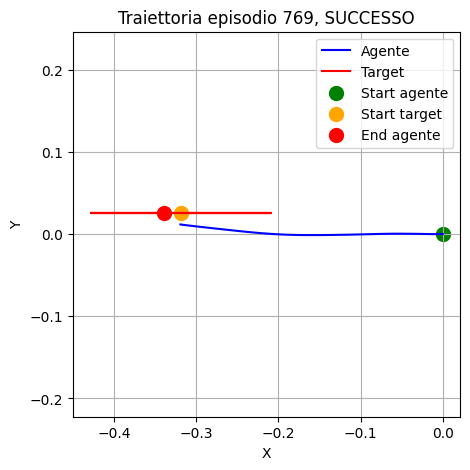

SUCCESSO Episode: 770, Step: 81, Counter: 561, Total reward: 768.6800537109375, final state: tensor([ 0.2256, -0.4119,  0.2190, -0.3931])
Episode: 770, Step: 81, Counter: 561, Total reward: 768.6800537109375, final state: tensor([ 0.2256, -0.4119,  0.2190, -0.3931])
SUCCESSO Episode: 771, Step: 199, Counter: 562, Total reward: 951.3014526367188, final state: tensor([ 0.0714, -0.2470,  0.0573, -0.2434])
SUCCESSO Episode: 772, Step: 102, Counter: 563, Total reward: 661.3366088867188, final state: tensor([ 0.4704, -0.0290,  0.4829, -0.0165])
SUCCESSO Episode: 773, Step: 93, Counter: 564, Total reward: 781.8489990234375, final state: tensor([0.3650, 0.0548, 0.3560, 0.0502])
SUCCESSO Episode: 774, Step: 118, Counter: 565, Total reward: 807.3423461914062, final state: tensor([-0.5538,  0.1416, -0.5366,  0.1332])
SUCCESSO Episode: 775, Step: 91, Counter: 566, Total reward: 757.36572265625, final state: tensor([0.4892, 0.1171, 0.4814, 0.1016])
SUCCESSO Episode: 776, Step: 134, Counter: 567, To

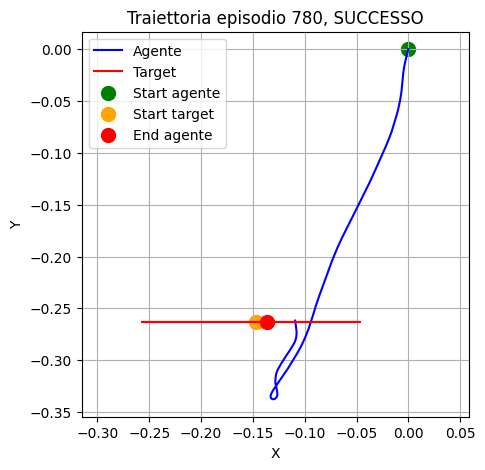

Episode: 780, Step: 170, Counter: 570, Total reward: 830.5205078125, final state: tensor([-0.1092, -0.2609, -0.1266, -0.2631])
SUCCESSO Episode: 781, Step: 201, Counter: 571, Total reward: 852.3411254882812, final state: tensor([ 0.2376, -0.2392,  0.2505, -0.2252])
SUCCESSO Episode: 782, Step: 245, Counter: 572, Total reward: 647.677001953125, final state: tensor([ 0.2884, -0.0957,  0.2926, -0.0763])
SUCCESSO Episode: 783, Step: 79, Counter: 573, Total reward: 767.9490356445312, final state: tensor([ 0.1692, -0.3962,  0.1575, -0.4045])
SUCCESSO Episode: 784, Step: 84, Counter: 574, Total reward: 670.6068115234375, final state: tensor([ 0.1758, -0.0538,  0.1639, -0.0482])
SUCCESSO Episode: 785, Step: 178, Counter: 575, Total reward: 940.558349609375, final state: tensor([ 0.0886, -0.3387,  0.1066, -0.3320])
SUCCESSO Episode: 786, Step: 135, Counter: 576, Total reward: 807.6538696289062, final state: tensor([0.2866, 0.3618, 0.2669, 0.3628])
SUCCESSO Episode: 787, Step: 147, Counter: 577,

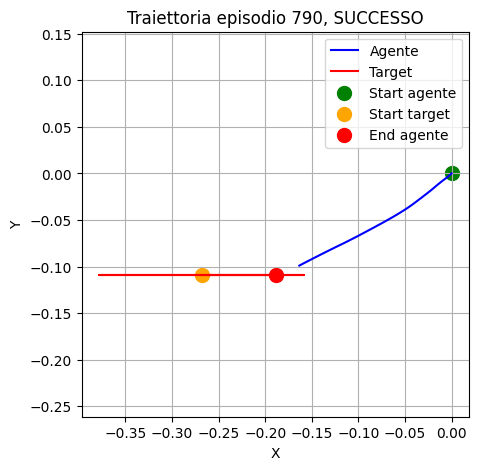

Episode: 790, Step: 53, Counter: 580, Total reward: 643.43798828125, final state: tensor([-0.1675, -0.1011, -0.1781, -0.1091])
SUCCESSO Episode: 791, Step: 23, Counter: 581, Total reward: 582.259765625, final state: tensor([ 0.0476,  0.0056,  0.0645, -0.0032])
SUCCESSO Episode: 793, Step: 198, Counter: 582, Total reward: 796.21142578125, final state: tensor([ 0.1701, -0.1144,  0.1751, -0.0957])
SUCCESSO Episode: 794, Step: 163, Counter: 583, Total reward: 765.415283203125, final state: tensor([-0.0233,  0.2220, -0.0418,  0.2176])
SUCCESSO Episode: 795, Step: 131, Counter: 584, Total reward: 809.089599609375, final state: tensor([0.2555, 0.4999, 0.2424, 0.4913])
SUCCESSO Episode: 796, Step: 138, Counter: 585, Total reward: 724.1527099609375, final state: tensor([-0.3156, -0.4136, -0.3116, -0.3959])
SUCCESSO Episode: 797, Step: 58, Counter: 586, Total reward: 673.1571044921875, final state: tensor([0.2402, 0.0900, 0.2443, 0.0784])
SUCCESSO Episode: 798, Step: 351, Counter: 587, Total rew

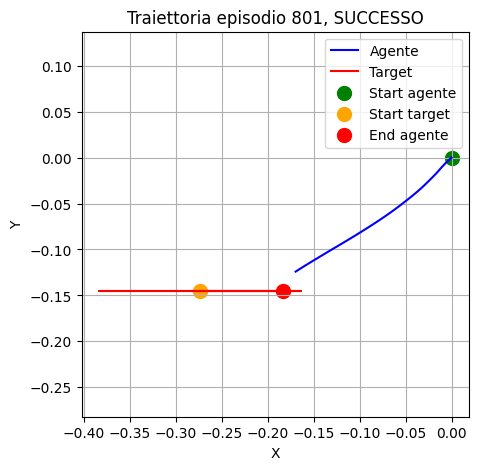

SUCCESSO Episode: 802, Step: 112, Counter: 591, Total reward: 788.20361328125, final state: tensor([-0.4978,  0.0093, -0.4906,  0.0191])
SUCCESSO Episode: 803, Step: 117, Counter: 592, Total reward: 809.716552734375, final state: tensor([-0.5132,  0.3145, -0.5024,  0.3004])
SUCCESSO Episode: 804, Step: 85, Counter: 593, Total reward: 730.084228515625, final state: tensor([-0.2851,  0.0313, -0.2963,  0.0400])
SUCCESSO Episode: 805, Step: 64, Counter: 594, Total reward: 690.2006225585938, final state: tensor([0.3848, 0.1581, 0.4001, 0.1509])
SUCCESSO Episode: 806, Step: 201, Counter: 595, Total reward: 859.1703491210938, final state: tensor([ 0.0601, -0.1849,  0.0430, -0.1757])
SUCCESSO Episode: 807, Step: 83, Counter: 596, Total reward: 723.163818359375, final state: tensor([-0.1613,  0.1811, -0.1770,  0.1695])
SUCCESSO Episode: 808, Step: 63, Counter: 597, Total reward: 685.4881591796875, final state: tensor([0.4697, 0.1667, 0.4841, 0.1618])
SUCCESSO Episode: 809, Step: 162, Counter: 5

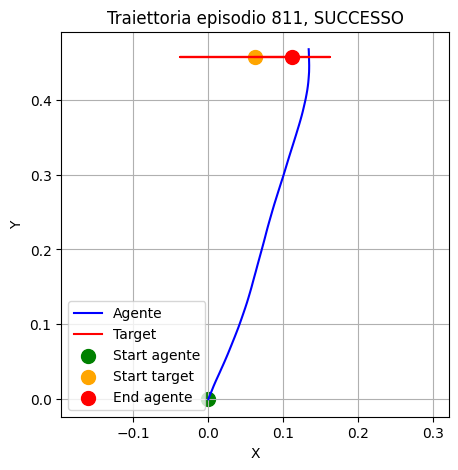

SUCCESSO Episode: 812, Step: 86, Counter: 601, Total reward: 772.785888671875, final state: tensor([-0.3429,  0.1765, -0.3447,  0.1900])
SUCCESSO Episode: 813, Step: 86, Counter: 602, Total reward: 741.5426025390625, final state: tensor([-0.3108,  0.0239, -0.3191,  0.0358])
SUCCESSO Episode: 814, Step: 128, Counter: 603, Total reward: 769.1807861328125, final state: tensor([-0.4340, -0.0638, -0.4433, -0.0496])
SUCCESSO Episode: 815, Step: 201, Counter: 604, Total reward: 837.6471557617188, final state: tensor([ 0.2218, -0.1713,  0.2262, -0.1524])
SUCCESSO Episode: 816, Step: 131, Counter: 605, Total reward: 819.727294921875, final state: tensor([0.2340, 0.2985, 0.2149, 0.2954])
SUCCESSO Episode: 817, Step: 85, Counter: 606, Total reward: 752.621337890625, final state: tensor([ 0.4016, -0.2471,  0.3972, -0.2654])
SUCCESSO Episode: 818, Step: 165, Counter: 607, Total reward: 903.4923095703125, final state: tensor([-0.0417, -0.3581, -0.0507, -0.3476])
SUCCESSO Episode: 819, Step: 89, Coun

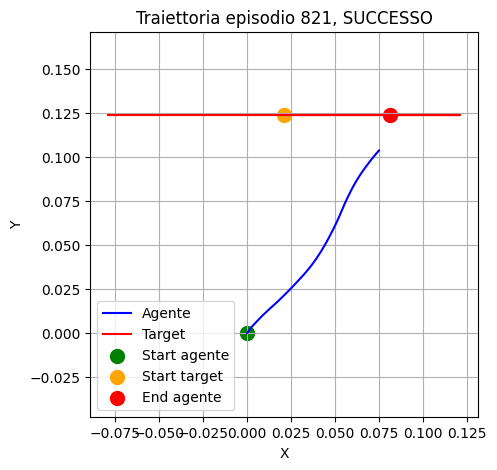

SUCCESSO Episode: 822, Step: 114, Counter: 611, Total reward: 803.8284301757812, final state: tensor([-0.5050,  0.2675, -0.4909,  0.2553])
SUCCESSO Episode: 823, Step: 87, Counter: 612, Total reward: 760.22705078125, final state: tensor([-0.3868,  0.3100, -0.3823,  0.3261])
SUCCESSO Episode: 824, Step: 62, Counter: 613, Total reward: 698.3013916015625, final state: tensor([0.3138, 0.1913, 0.3220, 0.2087])
SUCCESSO Episode: 825, Step: 149, Counter: 614, Total reward: 733.9149169921875, final state: tensor([-0.4255, -0.1985, -0.4138, -0.1969])
SUCCESSO Episode: 826, Step: 53, Counter: 615, Total reward: 653.0737915039062, final state: tensor([-0.1473, -0.1205, -0.1469, -0.1399])
SUCCESSO Episode: 827, Step: 114, Counter: 616, Total reward: 771.806884765625, final state: tensor([-0.4668,  0.4370, -0.4524,  0.4370])
SUCCESSO Episode: 828, Step: 199, Counter: 617, Total reward: 951.740478515625, final state: tensor([ 0.0578, -0.2055,  0.0438, -0.1945])
SUCCESSO Episode: 829, Step: 46, Count

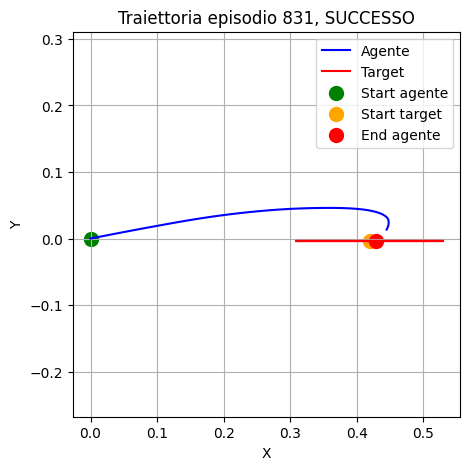

SUCCESSO Episode: 832, Step: 93, Counter: 621, Total reward: 747.9976806640625, final state: tensor([0.5503, 0.3647, 0.5422, 0.3514])
SUCCESSO Episode: 833, Step: 88, Counter: 622, Total reward: 747.4623413085938, final state: tensor([-0.2941,  0.4161, -0.2915,  0.4306])
SUCCESSO Episode: 834, Step: 117, Counter: 623, Total reward: 817.6870727539062, final state: tensor([-0.4560,  0.3346, -0.4536,  0.3174])
SUCCESSO Episode: 835, Step: 87, Counter: 624, Total reward: 738.4325561523438, final state: tensor([-0.0858,  0.3940, -0.0894,  0.3780])
SUCCESSO Episode: 836, Step: 103, Counter: 625, Total reward: 755.6473388671875, final state: tensor([0.4354, 0.3244, 0.4381, 0.3059])
SUCCESSO Episode: 837, Step: 202, Counter: 626, Total reward: 817.406982421875, final state: tensor([ 0.2426, -0.2050,  0.2500, -0.1953])
SUCCESSO Episode: 838, Step: 55, Counter: 627, Total reward: 667.5394287109375, final state: tensor([-0.2964, -0.1034, -0.3091, -0.0970])
SUCCESSO Episode: 839, Step: 85, Counter

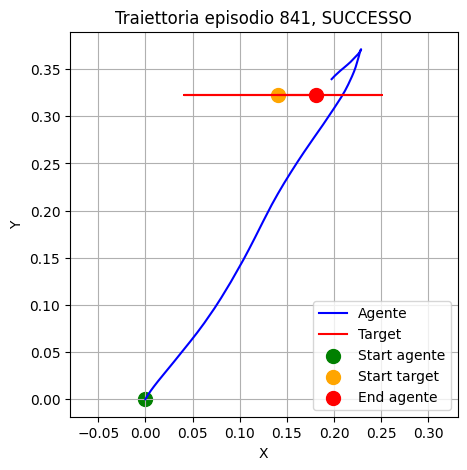

SUCCESSO Episode: 842, Step: 115, Counter: 631, Total reward: 782.6001586914062, final state: tensor([-0.4210,  0.3769, -0.4175,  0.3620])


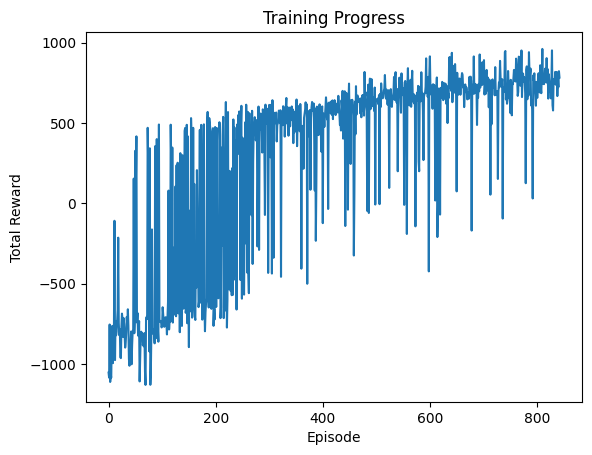

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from environment import TrackingEnv

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_MEMORY = 1600
NUM_NEURONS = 64
LR_CRITIC = 0.0005
LR_ACTOR = 0.001
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCH = 10
EARLY_STOPPING_EPISODES = 50
ENTROPY_COEFF = 0.01

def compute_advantages(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    advantages = []
    gae = 0
    values = torch.cat([values, torch.tensor([0], dtype=values.dtype, device=values.device)])  # Append a 0 for the last state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float)

def compute_returns(rewards, dones, gamma=0.99):
    returns = []
    G = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        G = reward + gamma * G * (1 - done)  # Reset if episode ended
        returns.insert(0, G)
    return returns

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()

        self.noise_std = 0.1
        
        self.fc1 = nn.Linear(state_dim, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        
        # Output per la media (mu)
        self.mu_layer = nn.Linear(NUM_NEURONS, action_dim)
        
        # Output per la deviazione standard (log_sigma)
        self.log_sigma_layer = nn.Linear(NUM_NEURONS, action_dim)

    def add_noise_to_target(self, state):
        state = state.clone()
        if state.dim() == 1:
            state[2:4] += torch.normal(0.0, self.noise_std, size=(2,), device=state.device)
        else:
            state[:, 2:4] += torch.normal(0.0, self.noise_std, size=state[:, 2:4].shape, device=state.device)
        return state


    def forward(self, state):#, exploration_term):

        #state = self.add_noise_to_target(state)

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # Media delle azioni
        mu = self.mu_layer(x)
        
        # Deviazione standard (softplus per garantire positività)
        log_sigma = self.log_sigma_layer(x)
        sigma = F.softplus(log_sigma) + 1e-5 # 1e-5 per evitare log(0)
        #sigma = F.softplus(log_sigma) + exploration_term + 1e-5 # 1e-5 per evitare log(0)

        return mu, sigma

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PPOAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = []
    
    def get_action(self, state):
        mu, sigma = self.actor.forward(state)#, exploration_term)
        dist = torch.distributions.Normal(mu, sigma)
        action = dist.rsample()  # Usa reparametrization trick per il backprop
        log_prob = dist.log_prob(action).sum(dim=-1)  # Somma log-prob per dimensione azione
        return action.detach(), log_prob

    def store_transition(self, transition):
        self.buffer.append(transition)

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):

    #     pos = state[:2]
    #     target = state[2:4]
    #     next_pos = next_state[:2]

    #     to_target = F.normalize(target - pos, dim=0)          # direzione ideale
    #     action_dir = F.normalize(action, dim=0)               # direzione dell’azione
    #     direction_reward = torch.dot(action_dir, to_target)

    #     distance = torch.norm(next_state[:2] - next_state[2:4])

    #     if distance < tolerance:
    #         reward = 100
    #     else:
    #         reward = direction_reward.item()
    #     if rimbalzato:
    #         reward += -10
        
    #     return reward - step * 0.001

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):
    #     # Calcola la ricompensa basata sulla distanza tra il primo e il secondo oggetto
    #     distance = torch.norm(state[:2] - state[2:4])
    #     distance_post = torch.norm(next_state[:2] - next_state[2:4])
    #     pos = state[:2]
    #     target = state[2:4]
    #     next_pos = next_state[:2]
    #     #next_pos = torch.tensor(next_pos, dtype=torch.float32)

    #     to_target = F.normalize(target - pos, dim=0)          # direzione ideale
    #     action_dir = F.normalize(action, dim=0)               # direzione dell’azione
    #     direction_reward = torch.dot(action_dir, to_target)   # massimo = 1, minimo = -1
    #     if distance < tolerance:
    #         reward = 100
    #     elif distance < 2 * tolerance and direction_reward >= 0.90: # 0.8
    #         reward = 5
    #     elif distance < 2 * tolerance and direction_reward < 0.90:
    #         reward = - 2
    #     else:
    #         reward = - 2 * distance_post.item() + direction_reward.item()
    #     if rimbalzato:
    #         reward += -10
    #     return reward

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):

    #     pos = state[:2]
    #     target = state[2:4]
    #     next_pos = next_state[:2]
    #     #next_pos = torch.tensor(next_pos, dtype=torch.float32)

        # to_target = F.normalize(target - pos, dim=0)          # direzione ideale
        # action_dir = F.normalize(action, dim=0)               # direzione dell’azione
        # direction_reward = torch.dot(action_dir, to_target)   # massimo = 1, minimo = -1

        # # Distanze
        # dist_before = torch.norm(pos - target)
        # dist_after = torch.norm(next_pos - target)
        # progress = dist_before - dist_after
        
        # step_penalty = 0.01 * step # 0.01

        # #Se raggiunge il target
        # if dist_after < tolerance:
        #    reward = 500 - 5 * step #if step > 100 else 500
        #    #reward = 500
        # else:
        #    #reward = "quanto mi avvicino" + "quanto vado nella direzione giusta"
        #    reward = 2 * progress + 5 * direction_reward  # pesi da tarare 2 5

        # if rimbalzato:
        #    reward += -5

        # return reward - step_penalty

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):
    #     pos = state[:2]
    #     target = state[2:4]
    #     next_pos = next_state[:2]
    #     next_target = next_state[2:4]

    #     # Direzione verso il target attuale
    #     to_target = F.normalize(target - pos, dim=0)
    #     action_dir = F.normalize(action, dim=0)
    #     direction_reward = torch.dot(action_dir, to_target)  # [-1, 1]

    #     # Distanze
    #     dist_before = torch.norm(pos - target)
    #     dist_after = torch.norm(next_pos - next_target)
    #     progress = dist_before - dist_after

    #     # Penalità temporale
    #     step_penalty = 0.01 * step

        # # Se il target è vicino
        # if dist_after < tolerance:
        #     reward = 500 - step  # incentiviamo ad arrivare presto
        # else:
        #     reward = 2 * progress + 5 * direction_reward

        #     # Penalizza l’allontanamento
        #     if progress < 0:
        #         reward += 8 * progress  # doppia penalità

        #     if rimbalzato:
        #         reward += -10

        # return reward - step_penalty

    def reward_function(self, state, action, next_state, step, tolerance, rimbalzato, attached_counter):
        pos = state[:2]
        target = state[2:4]
        next_pos = next_state[:2]
        next_target = next_state[2:4]

        # Direzione verso il target attuale
        to_target = F.normalize(target - pos, dim=0)
        action_dir = F.normalize(action, dim=0)
        direction_reward = torch.dot(action_dir, to_target)

        # Distanze
        dist_before = torch.norm(pos - target)
        dist_after = torch.norm(next_pos - next_target)
        progress = dist_before - dist_after
        dist_td = torch.norm(next_pos - target)
        

        # Penalità temporale
        step_penalty = 0.01 * step

        if 

    
    def update(self):
        torch.autograd.set_detect_anomaly(True)
        states, actions, rewards, dones, old_log_probs = zip(*self.buffer)
        old_log_probs = torch.stack(old_log_probs)
        states = torch.stack(states)
        actions = torch.stack(actions).float()
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        values = self.critic(states).squeeze()
        advantages = compute_advantages(rewards, values.detach(), dones)
        returns = compute_returns(rewards, dones)  # Compute Monte Carlo returns
        returns = torch.tensor(returns, dtype=torch.float32)
        
        for _ in range(K_EPOCH):
            means, stds = self.actor(states)
            dist = torch.distributions.Normal(means, stds)
            entropy = dist.entropy().sum(dim=-1).mean()  # media sull’intero batch
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advantages
            policy_loss = -torch.min(surr1, surr2).mean() - ENTROPY_COEFF * entropy
            values_pred =self.critic(states).squeeze()
            value_loss = F.mse_loss(values_pred, returns)

            total_loss = policy_loss + value_loss

            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            #policy_loss.backward()
            #value_loss.backward()
            total_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        self.buffer.clear()

def train_ppo(env=None, num_episodes=2000):
    if env is None:
        env = TrackingEnv()
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]
    agent = PPOAgent(num_inputs, num_actions)
    reward_history = []
    success_history = []
    counter = 0
    tolerance = 0.02 #0.05
    
    for episode in range(num_episodes):
        target = np.random.uniform(-0.5, 0.5, size=(2,))
        target = torch.tensor(target, dtype=torch.float32)
        state, _ = env.reset(target=target)
        done = False
        total_reward = 0
        state = torch.tensor(state, dtype=torch.float32)
        trajectory = []
        target_trajectory = []
        step = 0
        attached_counter = 0
        
        while not done:
            step += 1
            #print(f"state: {state}, target: {target}")
            trajectory.append(state[:2].detach().numpy())
            target_trajectory.append(state[2:].detach().numpy())
            action, log_prob = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            #if torch.norm(next_state[:2] - next_state[2:4])<tolerance or truncated:
            #    done = True
            if torch.norm(next_state[:2] - target_trajectory[-1])<tolerance:
                attached_counter += 1
            
            reward = agent.reward_function(state, action, next_state, step, tolerance, rimbalzato, attached_counter)
            
            if attached_counter > 5 or truncated:
                done = True

            agent.store_transition((state, action, reward, done, log_prob))
            state = next_state
            total_reward += reward
        
        if torch.norm(next_state[:2] - next_state[2:4])<tolerance:
            counter += 1
            success_history.append(1)
            # PLOTTING TRAIETTORIA A SUCCESSO
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            print(f"SUCCESSO Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state}")
            
            if counter % 10 == 0:

                plt.figure(figsize=(5, 5))
                plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
                plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
                plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
                plt.scatter(*target_trajectory[0], color='orange', label='Start target', s=100)
                plt.scatter(*target_trajectory[-1], color='red', label='End agente', s=100)
                plt.title(f"Traiettoria episodio {episode}, SUCCESSO")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
                plt.grid()
                plt.axis('equal')
                plt.show()

        else:
            success_history.append(0)

        reward_history.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state}")

        # if total_reward > 0:

            # trajectory = np.array(trajectory)
            # #target = next_state[2:4].detach().numpy()  # x_target, y_target
            # target_trajectory = np.array(target_trajectory)

            # plt.figure(figsize=(5, 5))
            # plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
            # plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], linestyle='--', label="Target", color='red')
            # plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
            # plt.scatter(*target_trajectory[0], color='orange', label='Start target', s=100)
            # plt.title(f"Traiettoria episodio {episode}")
            # plt.xlabel("X")
            # plt.ylabel("Y")
            # plt.legend()
            # plt.grid()
            # plt.axis('equal')
            # plt.show()
        
        if len(reward_history)>EARLY_STOPPING_EPISODES and all(s == 1 for s in success_history[-EARLY_STOPPING_EPISODES:]):
            break

        if len(agent.buffer) >= MAX_MEMORY:
            agent.update()
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


    return agent

if __name__ == "__main__":
    trained_agent = train_ppo()


In [2]:
def test_agent_with_random_targets(agent, env=None, num_episodes=100, target_sampler=None, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    agent.eval()

    final_distances = []
    success_counter = 0

    for ep in range(num_episodes):
        # Genera un target casuale (es. all’interno di uno spazio 2D limitato)
        if target_sampler:
            target = target_sampler()
            target = torch.tensor(target, dtype=torch.float32)
        else:
            target = np.random.uniform(low=-0.5, high=0.5, size=(2,))  # Default sampler
            target = torch.tensor(target, dtype=torch.float32)

        state, _ = env.reset(target=target)
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []

        while not done:
            trajectory.append(state.detach().numpy())
            action, _ = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state
            step += 1

        trajectory = np.array(trajectory)
        final_dist = np.linalg.norm(state[:2] - state[2:4])
        final_distances.append(final_dist)
        print(f"[Episode {ep}] Steps: {step}, Final distance: {final_dist:.4f}")

        success = False

        if final_dist < tolerance:
            success = True
            success_counter += 1

        # plt.figure(figsize=(5, 5))
        # plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        # plt.scatter(*state[2:4], color='red', label='Target', s=100)
        # plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        # plt.title(f"Test con target casuale – episodio {ep}, successo: {success}")
        # plt.xlabel("X")
        # plt.ylabel("Y")
        # plt.legend()
        # plt.grid()
        # plt.axis('equal')
        # plt.show()

    env.close()

    print(f"Media delle distanze finali: {np.mean(final_distances):.4f}, numero di successi: {success_counter}")

def target_sampler():
    # Genera target in un quadrato [-1, 1] x [-1, 1]
    return np.random.uniform(low=-0.5, high=0.5, size=(2,))


test_agent_with_random_targets(trained_agent, target_sampler=target_sampler)

[Episode 0] Steps: 87, Final distance: 0.0190
[Episode 1] Steps: 132, Final distance: 0.0180
[Episode 2] Steps: 114, Final distance: 0.0120
[Episode 3] Steps: 172, Final distance: 0.0145
[Episode 4] Steps: 173, Final distance: 0.0200
[Episode 5] Steps: 141, Final distance: 0.0087
[Episode 6] Steps: 90, Final distance: 0.0137
[Episode 7] Steps: 238, Final distance: 0.0198
[Episode 8] Steps: 50, Final distance: 0.0122
[Episode 9] Steps: 171, Final distance: 0.0101
[Episode 10] Steps: 190, Final distance: 0.0103
[Episode 11] Steps: 58, Final distance: 0.0094
[Episode 12] Steps: 138, Final distance: 0.0199
[Episode 13] Steps: 90, Final distance: 0.0136
[Episode 14] Steps: 115, Final distance: 0.0177
[Episode 15] Steps: 114, Final distance: 0.0137
[Episode 16] Steps: 198, Final distance: 0.0115
[Episode 17] Steps: 137, Final distance: 0.0175
[Episode 18] Steps: 166, Final distance: 0.0176
[Episode 19] Steps: 80, Final distance: 0.0175
[Episode 20] Steps: 88, Final distance: 0.0195
[Episode 